In [23]:
from astral import LocationInfo
import pytz
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# sys.path.append('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting')

from neuro_symbolic_demand_forecasting.encoders.encoders import PartOfDayEncoder, encode_is_holiday

from darts.timeseries import TimeSeries
from scipy.constants import convert_temperature

from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
%autoreload

In [16]:
AMS_TZ = pytz.timezone('Europe/Amsterdam')

city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
part_of_day_encoder = PartOfDayEncoder(city, AMS_TZ)

In [78]:
pv_05 = pd.read_csv('../data/2023_05_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
non_pv_05 = pd.read_csv('../data/2023_05_cleaned_non_pv.csv', parse_dates=True).set_index('readingdate')

pv_06 = pd.read_csv('../data/2023_06_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
non_pv_06 = pd.read_csv('../data/2023_06_cleaned_non_pv.csv', parse_dates=True).set_index('readingdate')

pv_07 = pd.read_csv('../data/2023_07_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
non_pv_07 = pd.read_csv('../data/2023_07_cleaned_non_pv.csv', parse_dates=True).set_index('readingdate')

pv_05.index = pd.to_datetime(pv_05.index)
non_pv_05.index = pd.to_datetime(non_pv_05.index)
pv_06.index = pd.to_datetime(pv_06.index)
non_pv_06.index = pd.to_datetime(non_pv_06.index)
pv_07.index = pd.to_datetime(pv_07.index)
non_pv_07.index = pd.to_datetime(non_pv_07.index)


pv05_ts = TimeSeries.from_dataframe(pv_05)
non_pv05_ts = TimeSeries.from_dataframe(non_pv_05)
pv06_ts = TimeSeries.from_dataframe(pv_06)
non_pv06_ts = TimeSeries.from_dataframe(non_pv_06)
pv07_ts = TimeSeries.from_dataframe(pv_07)
non_pv07_ts = TimeSeries.from_dataframe(non_pv_07)

actuals_df = pd.read_csv('../data/2023-04_to_08-amsterdam-actuals_filled_gaps.csv', parse_dates=['datetime_from']).set_index('datetime_from')[[ 'wind_speed', 'global_radiation', 'air_pressure', 'air_temperature', 'relative_humidity' ]]
actuals_df = actuals_df.resample('15min').mean()
actuals_df['temperature_c'] = actuals_df['air_temperature'].apply(lambda x: convert_temperature(x, 'K', 'C'))
actuals_df = TimeSeries.from_dataframe(actuals_df, freq='15min')

forecasts_df = pd.read_csv('../data/2023_weather_data_06_run_summer_from_04_to_08.csv', parse_dates=['valid_datetime']).set_index('valid_datetime')[[ 'wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m', 'r_instant_ground_2m' ]]
forecasts_df = forecasts_df.resample('15min').ffill()
forecasts_df = TimeSeries.from_dataframe(forecasts_df,freq='15min')

# prices = pd.read_csv('../data/2023-04_to_08_prices.csv', parse_dates=['DELIVERY_DATETIME']).set_index('DELIVERY_DATETIME')
# prices.index = prices.index.tz_convert(pytz.timezone('Europe/Amsterdam')).tz_localize(None)
# prices = TimeSeries.from_dataframe(prices, freq='15min')
# prices = prices[val_df.time_index.min():val_df.time_index.max()]

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the 

## Checking that thresholds of holidays and part of day match visually

/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.11/lib/python3.11/site-packages/darts/timeseries.py:4033: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


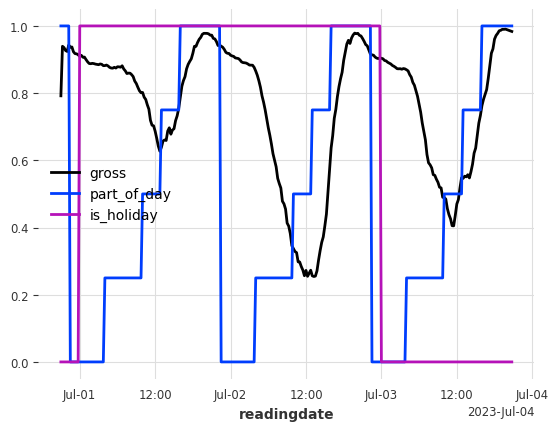

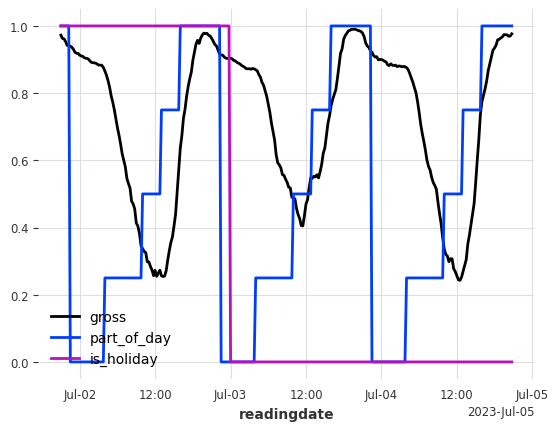

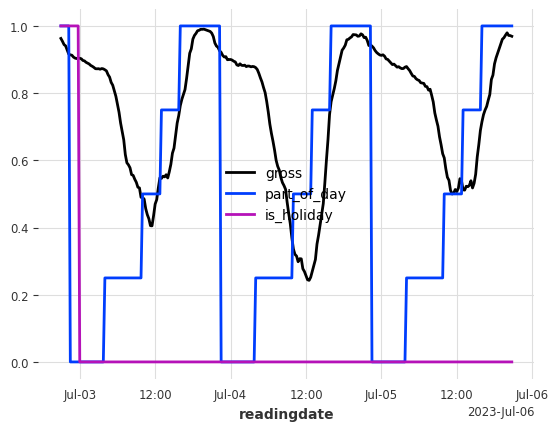

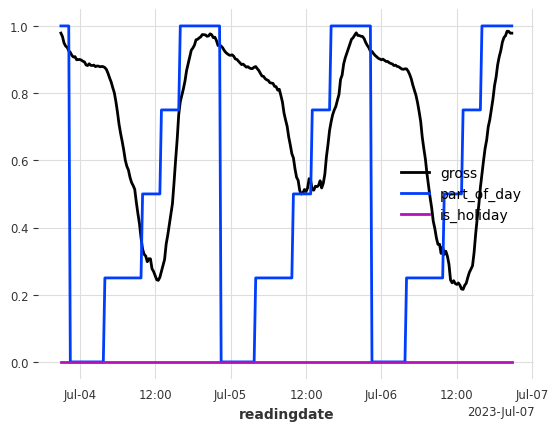

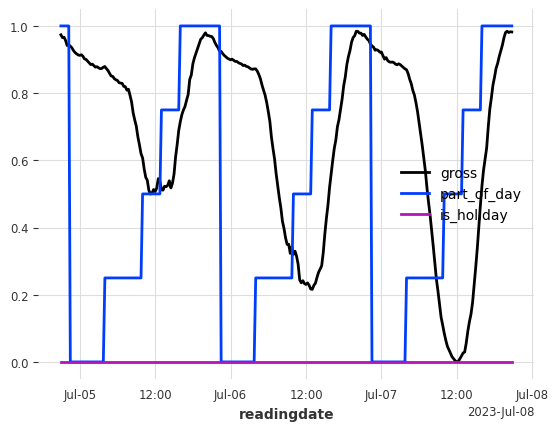

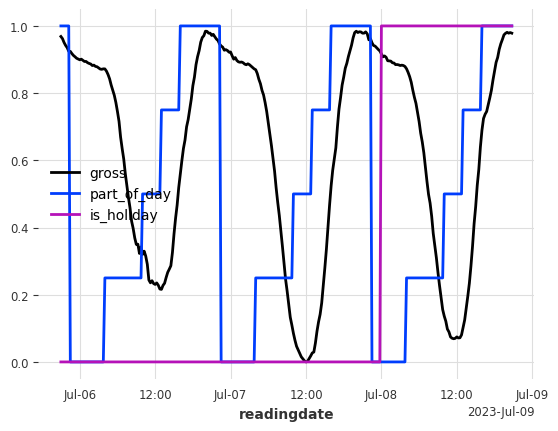

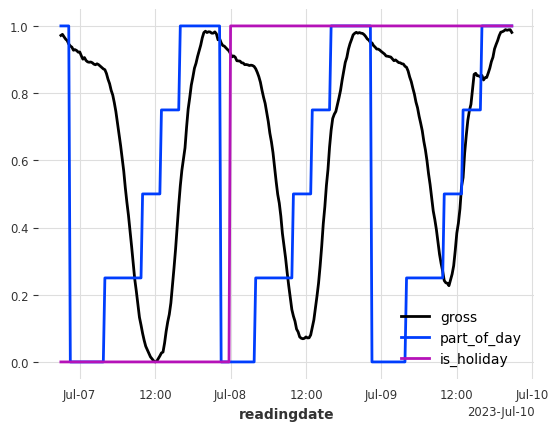

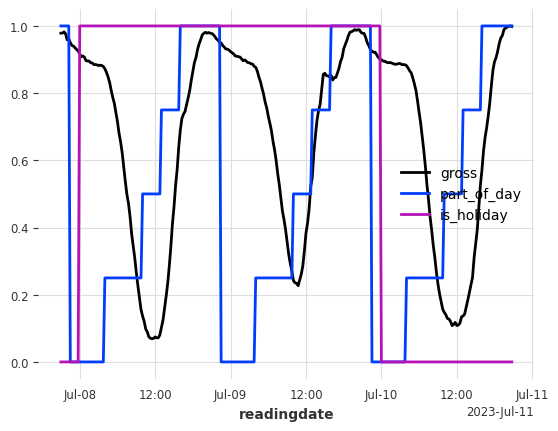

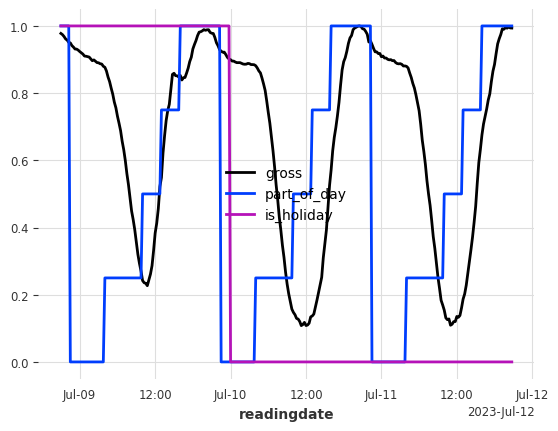

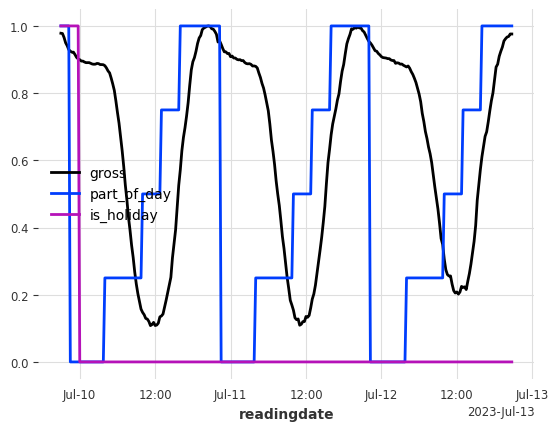

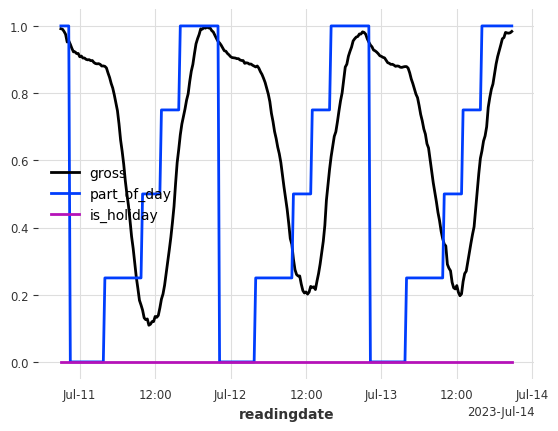

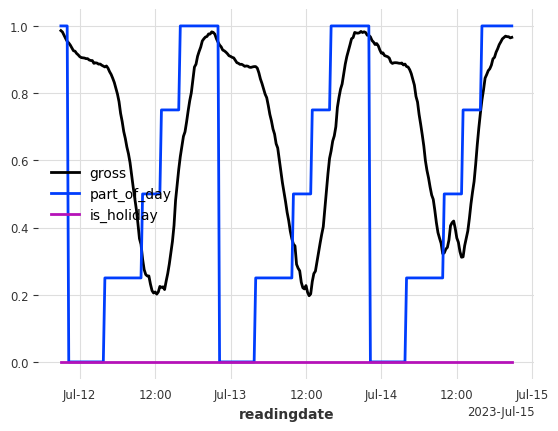

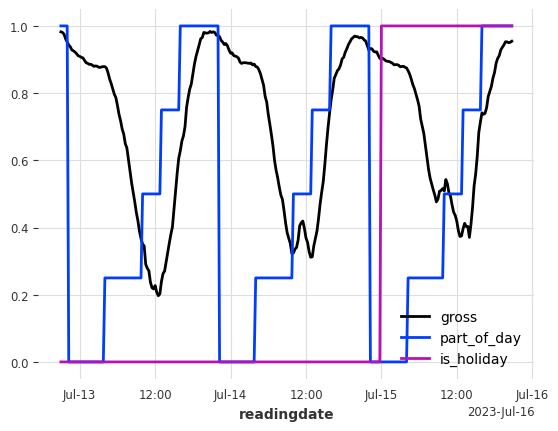

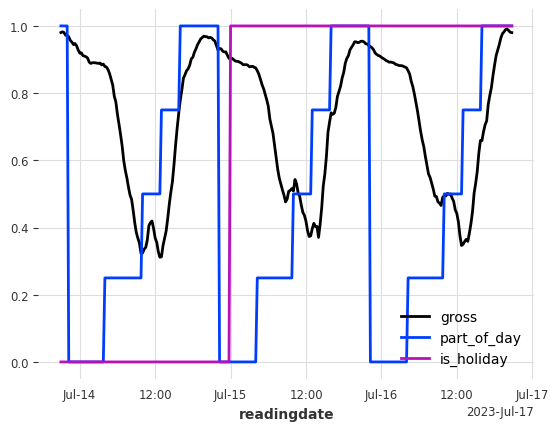

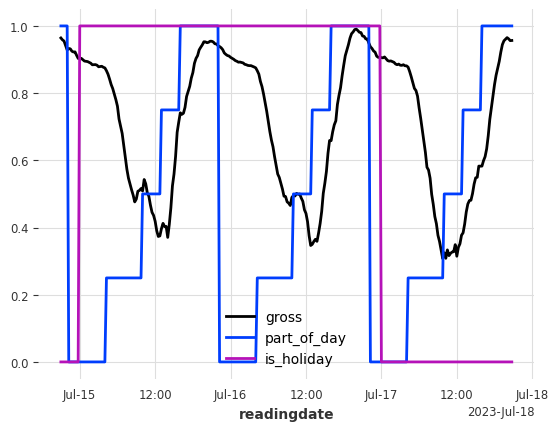

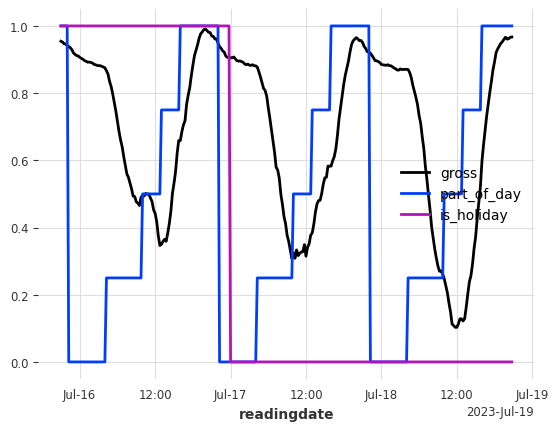

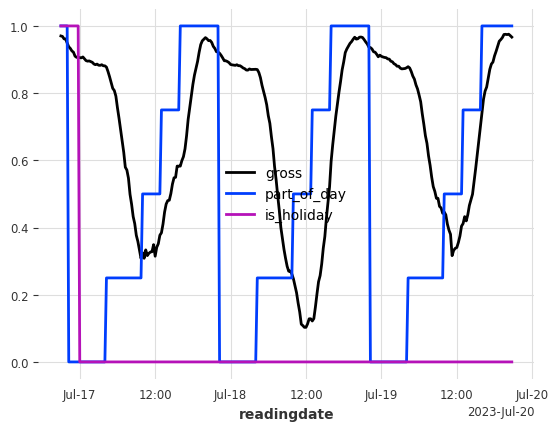

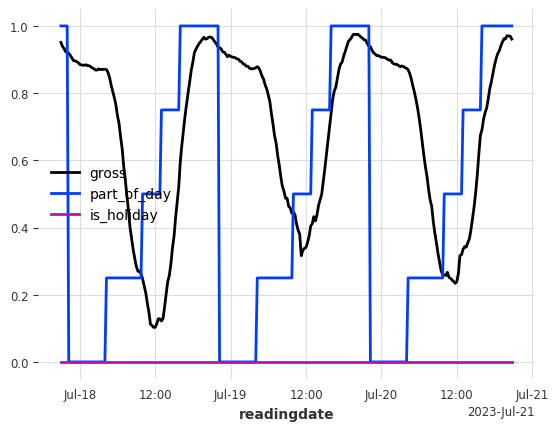

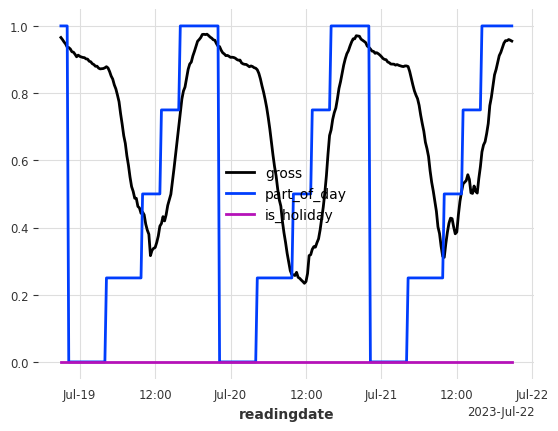

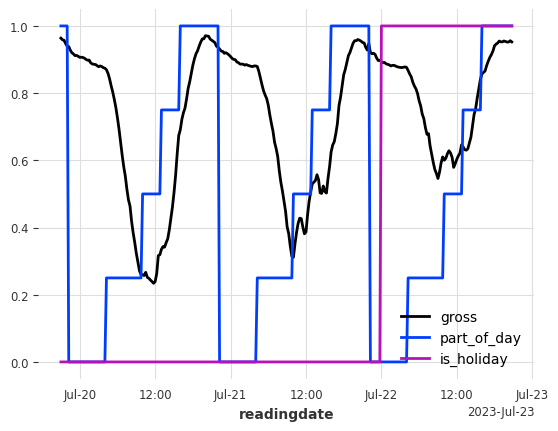

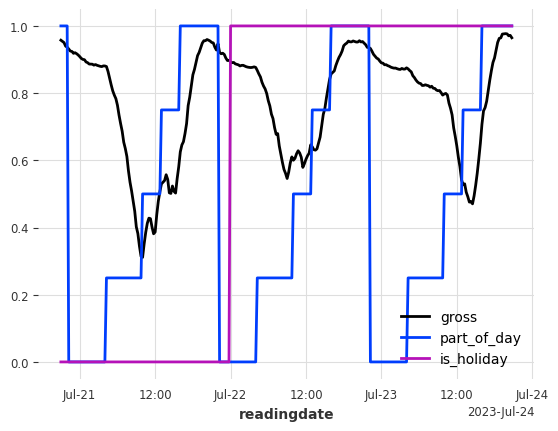

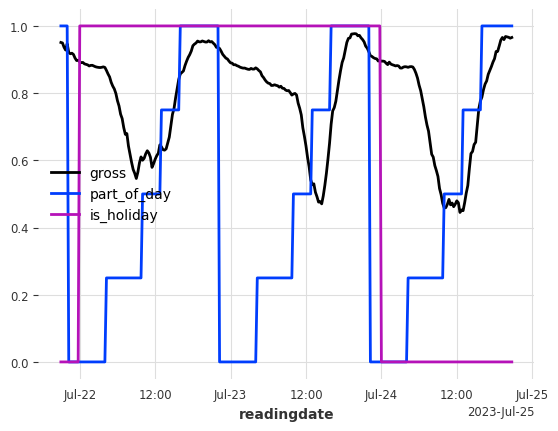

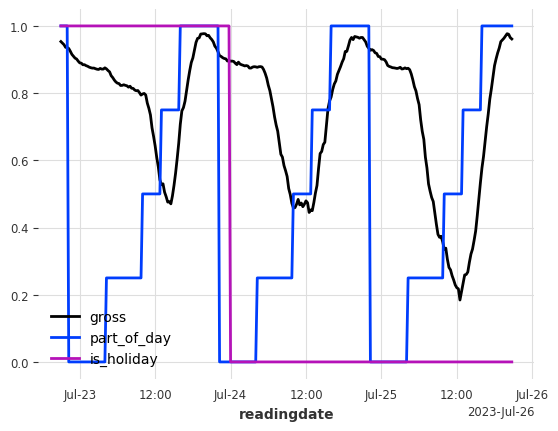

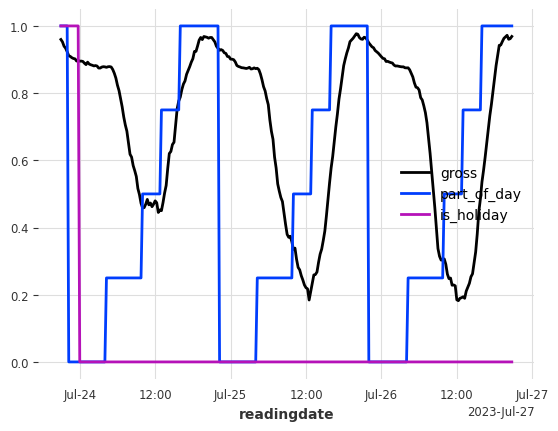

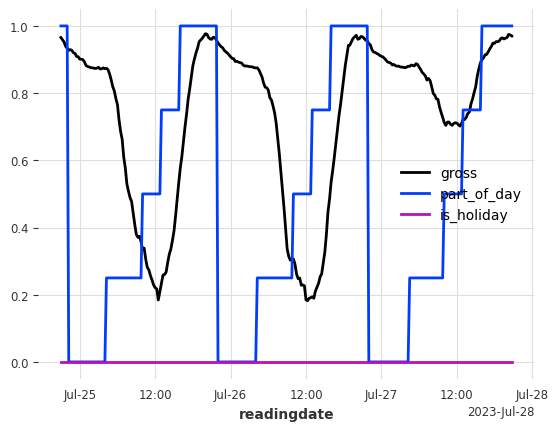

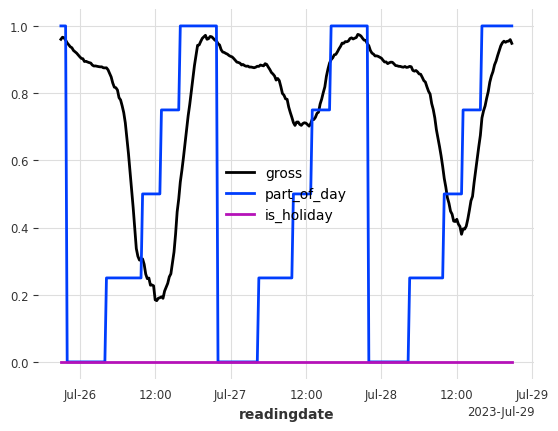

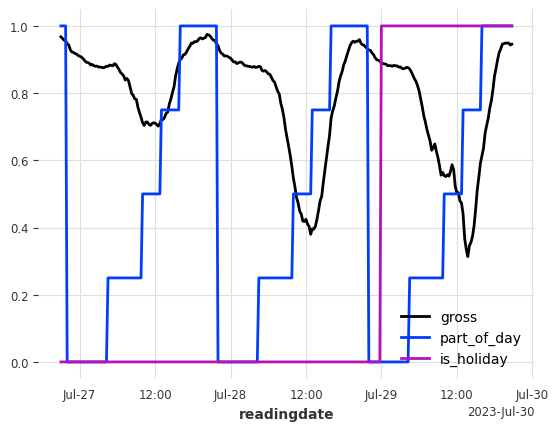

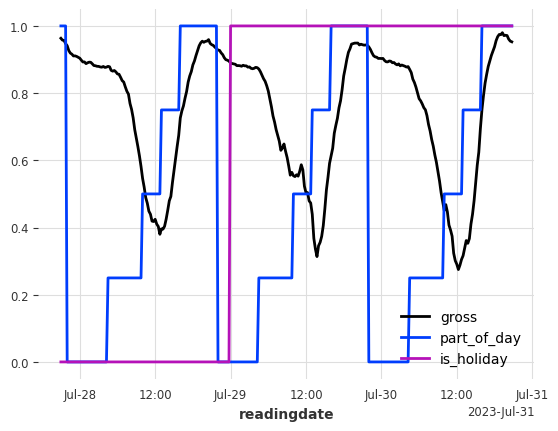

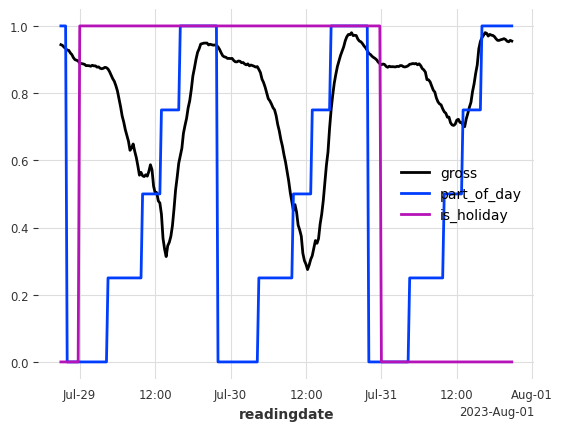

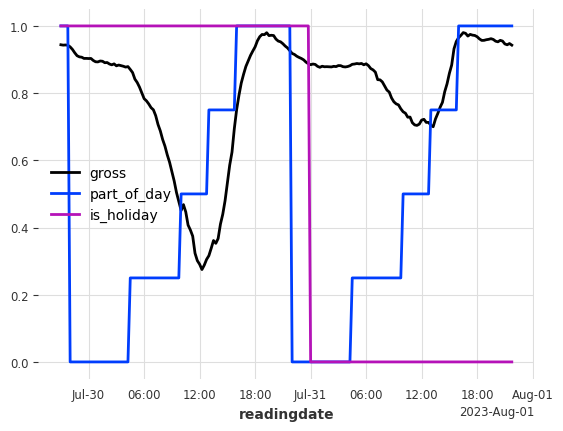

In [44]:
# pv05_ts.stack()
# ts = non_pv05_ts
ts = pv07_ts
scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
# scaler = Scaler(MinMaxScaler(feature_range=(-1, 1)))

scaled_ts = scaler.fit_transform(ts)
pod = TimeSeries.from_times_and_values(times=ts.time_index, values=part_of_day_encoder.encode(ts.time_index), columns=['part_of_day'])
hol = TimeSeries.from_times_and_values(times=ts.time_index, values=encode_is_holiday(ts.time_index), columns=['is_holiday'])

scaled_ts = scaled_ts.stack(pod).stack(hol)
step = 3
for i in range(0,30, 1):
    scaled_ts[i*96:(i+step)*96].plot(new_plot=True)

## Checking that temperature threshold match expectations

In [45]:
ts = pv07_ts
subset_weather = actuals_df[ts.time_index.min():ts.time_index.max()]

In [ ]:
hol = TimeSeries.from_times_and_values(times=ts.time_index, values=encode_is_holiday(ts.time_index), columns=['is_holiday'])


In [74]:
scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
# scaler = Scaler(MinMaxScaler(feature_range=(-1, 1)))

scaled_ts = scaler.fit_transform(ts)
subset_weather: TimeSeries = subset_weather[['temperature_c', 'relative_humidity']]
scaled_weather = scaler.fit_transform(subset_weather)


In [73]:
subset_weather.filter(subset_weather['temperature_c'] > 26)
subset_weather.

AttributeError: 'TimeSeries' object has no attribute 'filter'

<Axes: xlabel='datetime_from'>

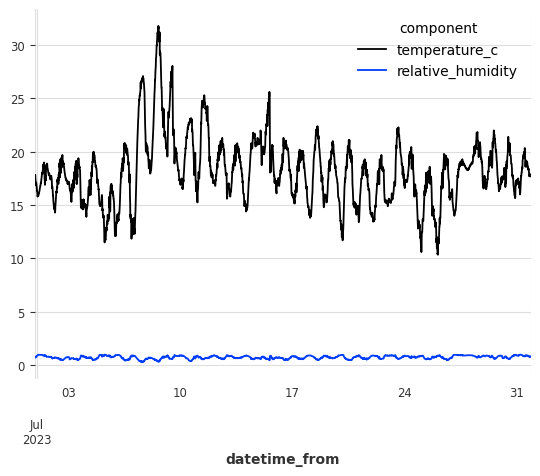

In [70]:
subset_df = subset_weather.pd_dataframe()
subset_df['is_hot'] = (subset_df['temperature_c'] > 26) & (subset_df['relative_humidity'] > 0.55)

<Axes: xlabel='datetime_from'>

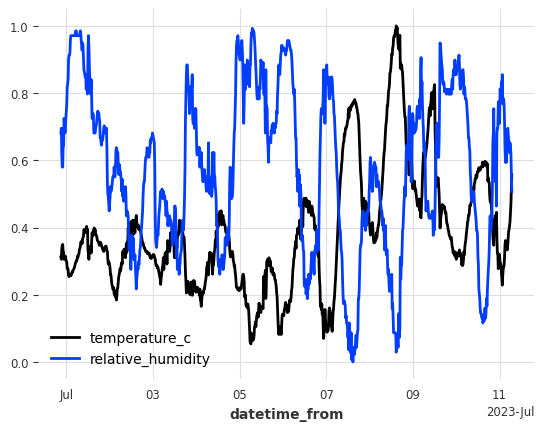

In [58]:
scaled_weather[0:1000].plot()

## Loss Curves

In [313]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_curves(_path: str, _title: str, ax):
    train_loss = pd.read_csv(f'{_path}/train_losses.csv')
    val_loss = pd.read_csv(f'{_path}/val_losses.csv')
    val_loss.columns = ['epoch', 'loss']
    train_loss['batch'] = train_loss['batch'].astype(str)
    all_losses= train_loss[train_loss['batch'].str.contains('45')] # aka, always the last loss term from an epoch
    
    all_losses.reset_index(inplace=True)
    all_losses.index.name = 'epoch'
    val_loss['epoch'] = val_loss['epoch'].astype(int)

    all_losses[['loss']].rename(columns={'loss': 'total_train_loss'}).plot(xlabel='epoch', ylabel='loss', title=f"{_title} - Train vs Validation Loss Curve", ax=ax)
    val_loss.set_index('epoch')[['loss']].rename(columns={'loss': 'total_val_loss'}).plot(ax=ax)


def plot_val_train_loss(val_loss, train_loss, ax, _title: str):
    train_loss.rename(columns={'total': 'total_train_loss'}).plot(xlabel='epoch', ylabel='loss', title=f"{_title} - Train vs Validation Loss Curve", ax=ax)
    val_loss.rename(columns={'total': 'total_val_loss'}).plot(ax=ax)



def plot_curves_of_loss_terms(_path: str, _title: str, key: str, _columns=['loss'], skip: (int, int) = (0,0), end_at: (int,int) = (0, 0)):
    t_skip , v_skip = skip
    t_end , v_end = end_at
    train_losses = pd.read_csv(f'{_path}/all_train_losses.csv').rename(columns={'mse': 'mean_squared_error', 'no_neg_pred_night': 'no_night_production', 'no_neg_pred_nonpv': 'regular_customer_no_production'})
    # cols = ['no_neg_pred_night', 'no_neg_pred_nonpv','morning_evening_peaks', 'airco']
    val_losses = pd.read_csv(f'{_path}/all_val_losses.csv').rename(columns={'mse': 'mean_squared_error', 'no_neg_pred_night': 'no_night_production', 'no_neg_pred_nonpv': 'regular_customer_no_production'})
    val_losses = val_losses.iloc[1:]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharex=True)
    train_losses_nth_epoch = train_losses.iloc[46::int(len(train_losses)/(len(val_losses)))].reset_index()

    # plot_loss_curves(_path, _title, axes[0])
    val_losses = val_losses.iloc[:-1]
    plot_val_train_loss(val_losses[['total']],train_losses_nth_epoch[['total']], axes[0], _title)
    
    if t_end > 0 and t_end >= t_skip:
        train_losses_nth_epoch[_columns].iloc[t_skip:t_end].plot(xlabel='batch', ylabel='loss', title=f'{_title} - Training Loss', ax=axes[1])
    else:
        train_losses_nth_epoch[_columns].iloc[t_skip:].plot(xlabel='epoch', ylabel='loss', title=f'{_title} - Training Loss', ax=axes[1])
    if v_end > 0 and v_end >= v_skip:
        val_losses[_columns].iloc[v_skip:v_end].plot(title=f'{_title} - Validation Loss', ax=axes[2], xlabel='epoch', ylabel='loss')
    else:
        val_losses[_columns].iloc[v_skip:].plot(title=f'{_title} - Validation Loss', ax=axes[2], xlabel='epoch', ylabel='loss')
    fig.savefig(f'../03_results/images/{key}_train_val_loss.png')

### Plotting loss curves

000 ['total', 'mean_squared_error']
001 ['total', 'mean_squared_error', 'morning_evening_peaks']
010 ['total', 'mean_squared_error', 'regular_customer_no_production']
011 ['total', 'mean_squared_error', 'regular_customer_no_production', 'morning_evening_peaks']
101 ['total', 'mean_squared_error', 'no_night_production', 'morning_evening_peaks']
100 ['total', 'mean_squared_error', 'no_night_production']
110 ['total', 'mean_squared_error', 'no_night_production', 'regular_customer_no_production']
111 ['total', 'mean_squared_error', 'no_night_production', 'regular_customer_no_production', 'morning_evening_peaks']


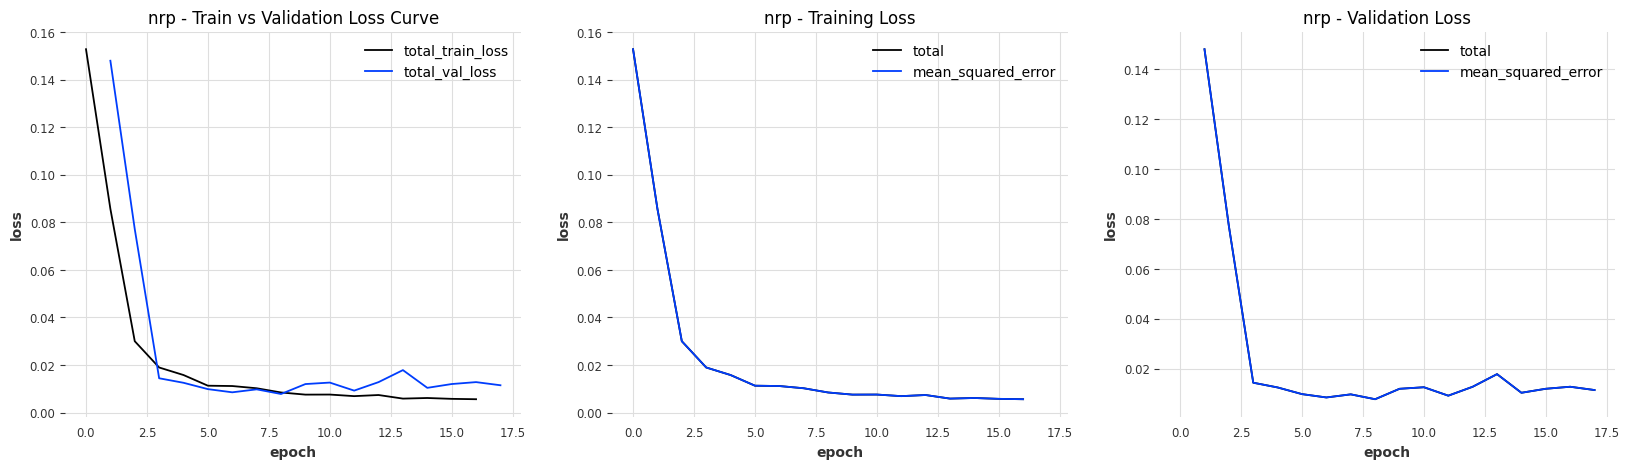

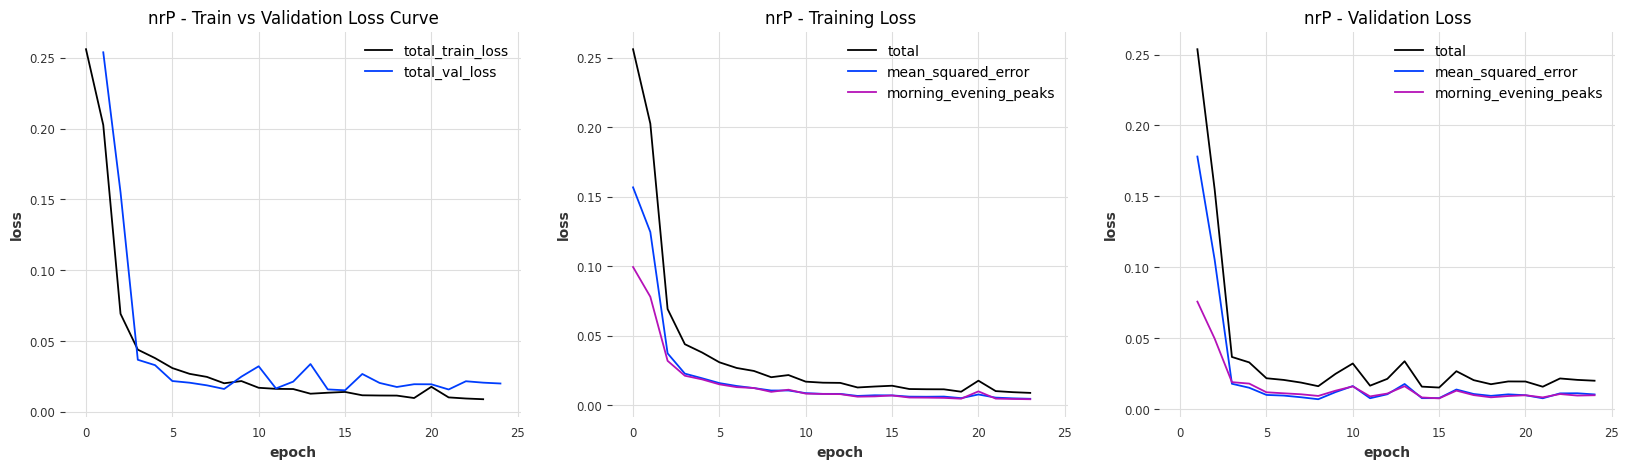

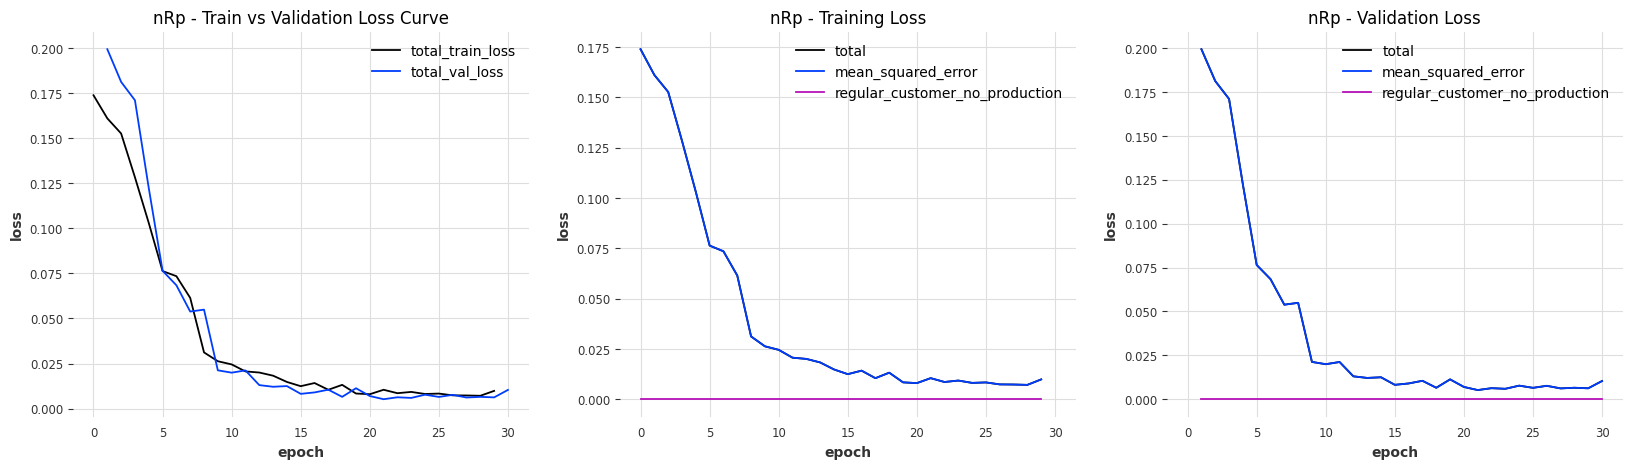

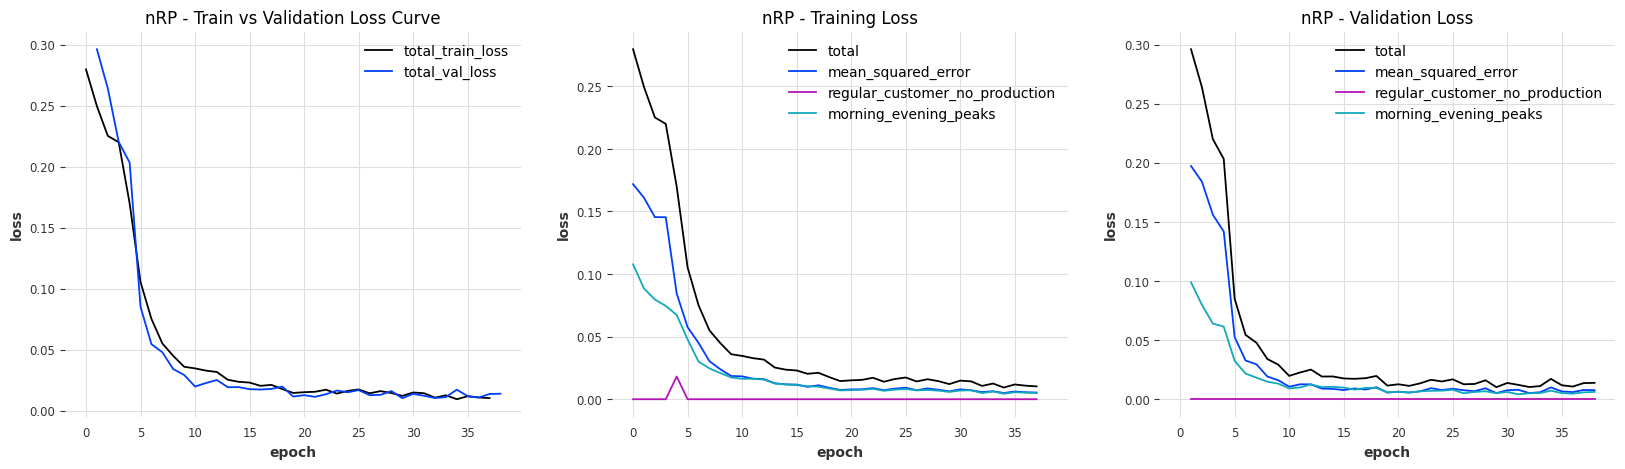

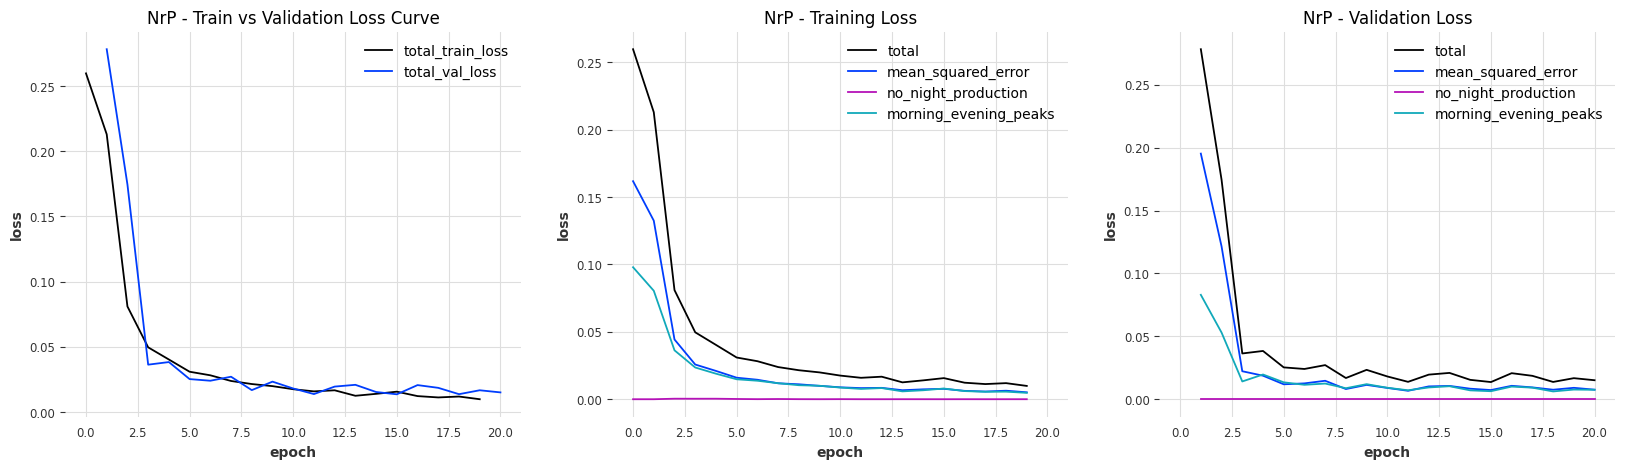

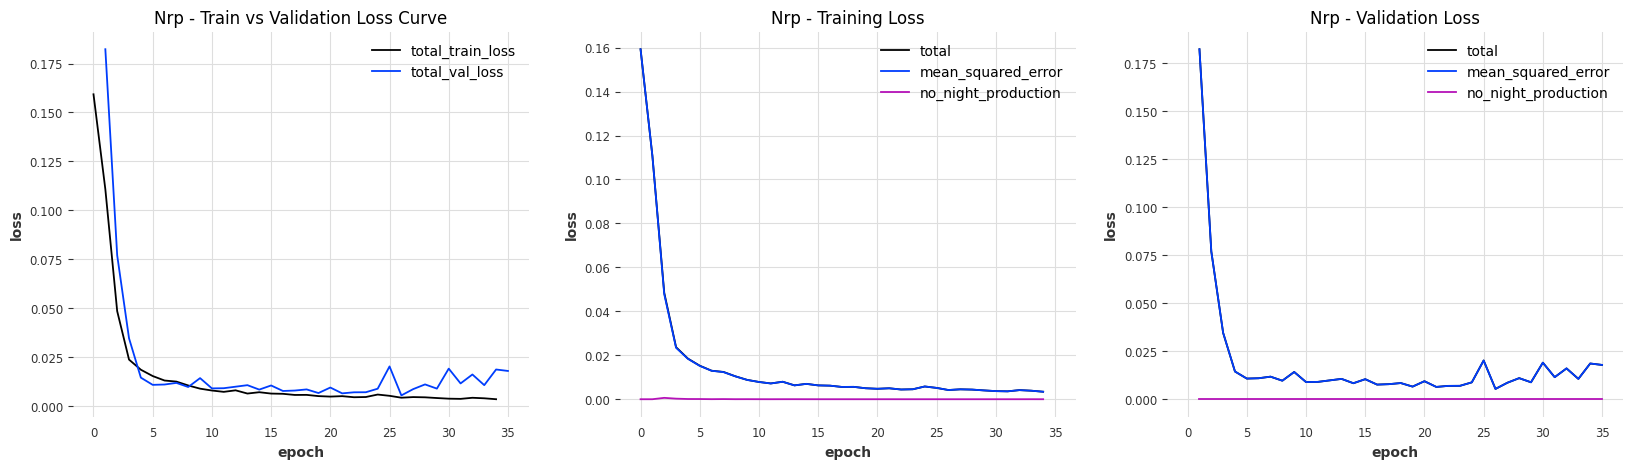

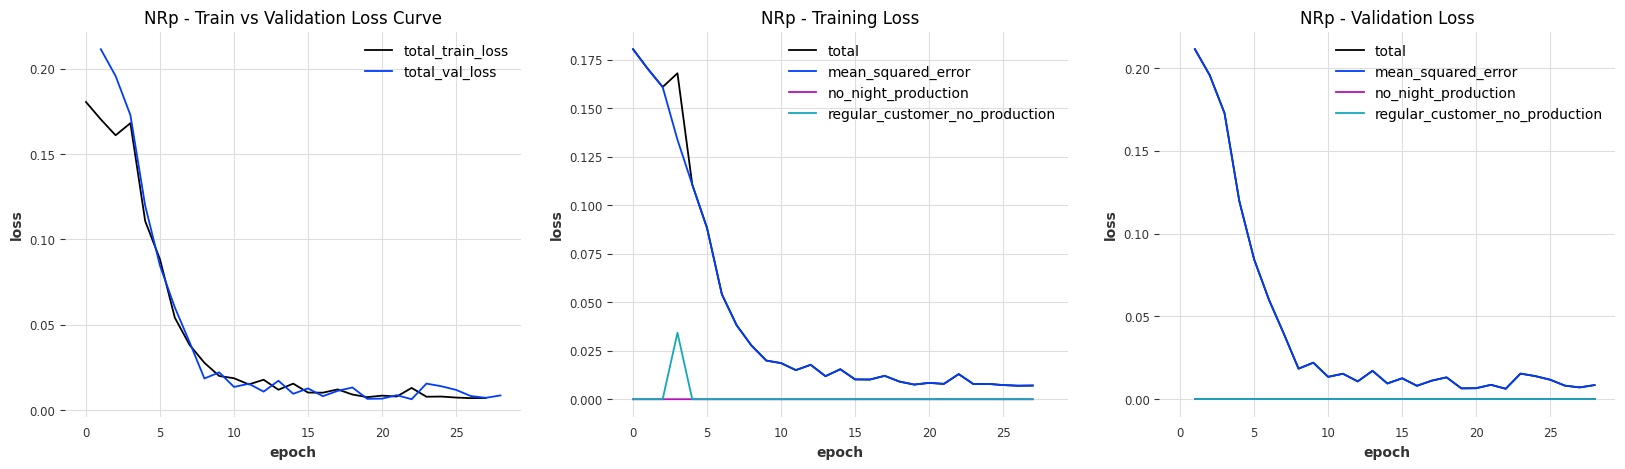

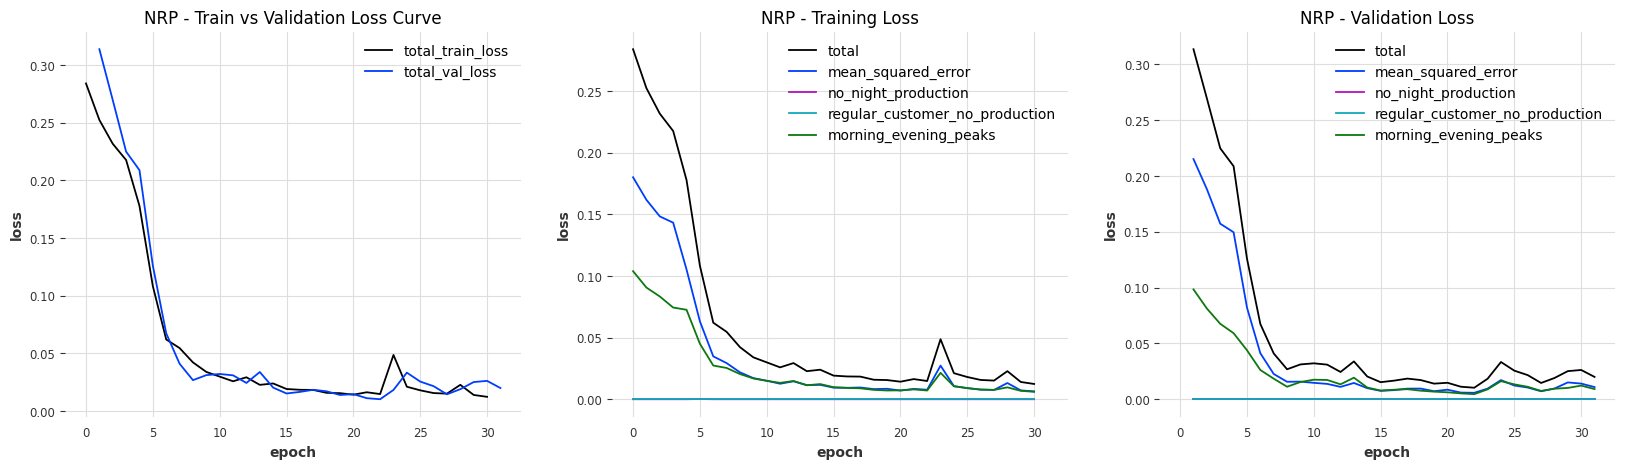

In [314]:
cols = ['no_night_production', 'regular_customer_no_production','morning_evening_peaks', 'airco']

for k,v in model_folders.items():
    selected_cols = ['total', 'mean_squared_error'] + [j for i,j in zip(k, cols) if i=='1']
    print(k, selected_cols)
    title = ''.join(['n' if k[0] == '0' else 'N', 'r' if k[1] == '0' else 'R', 'p' if k[2] == '0' else 'P'])
    plot_curves_of_loss_terms(v, title, k, selected_cols)

## Evaluation with Test Set

First run main_predict with the model you wish to evaluate

In [268]:
model_folders = {
'000': '../03_results/20240611_1704_tft_semantic_0000',
'001': '../03_results/20240611_1709_tft_semantic_0010',
'010': '../03_results/20240611_1709_tft_semantic_0100',
'011': '../03_results/20240611_1716_tft_semantic_0110',
'101': '../03_results/20240611_1716_tft_semantic_1010',
'100': '../03_results/20240611_1717_tft_semantic_1000',
'110': '../03_results/20240611_1720_tft_semantic_1100',
'111': '../03_results/20240611_1720_tft_semantic_1110',
}

In [269]:
test_range = '2023-07-31_2023-07-08'
val_range = ['2023-05-31_2023-05-24', '2023-06-30_2023-06-23']
train_range = ['2023-05-24_2023-05-09', '2023-06-23_2023-06-09']

pv_eval = '_pv_evaluation_data.csv'
pv_metrics='_pv_metrics.csv'
nonpv_eval = '_non_pv_evaluation_data.csv'
nonpv_metrics='_non_pv_metrics.csv'


def build_paths(rnge: list, suffixed_filename: str, _path: str):
    return [f'{_path}/{r}{suffixed_filename}' for r in rnge]



### Plot predicted vs actuals

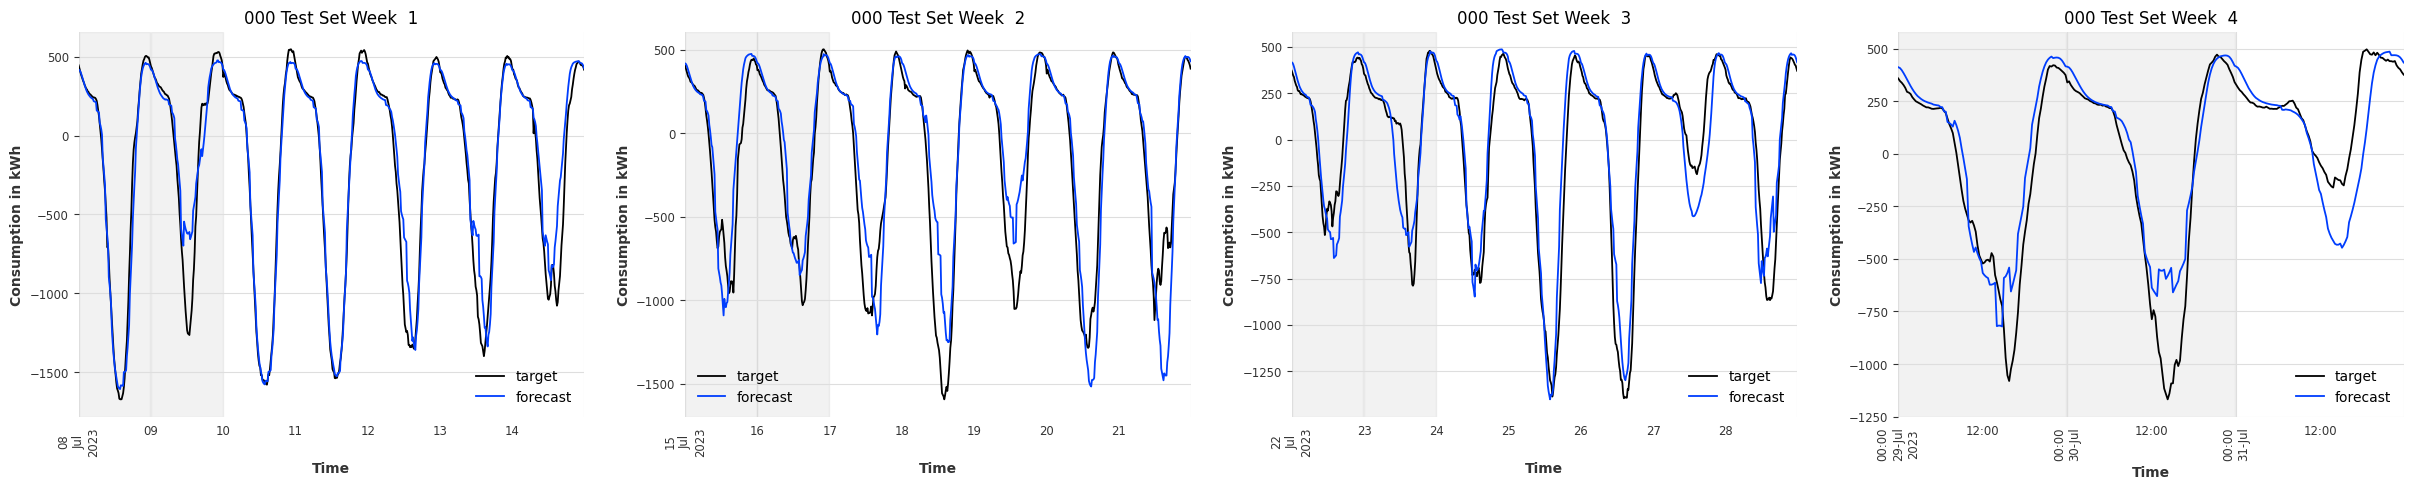

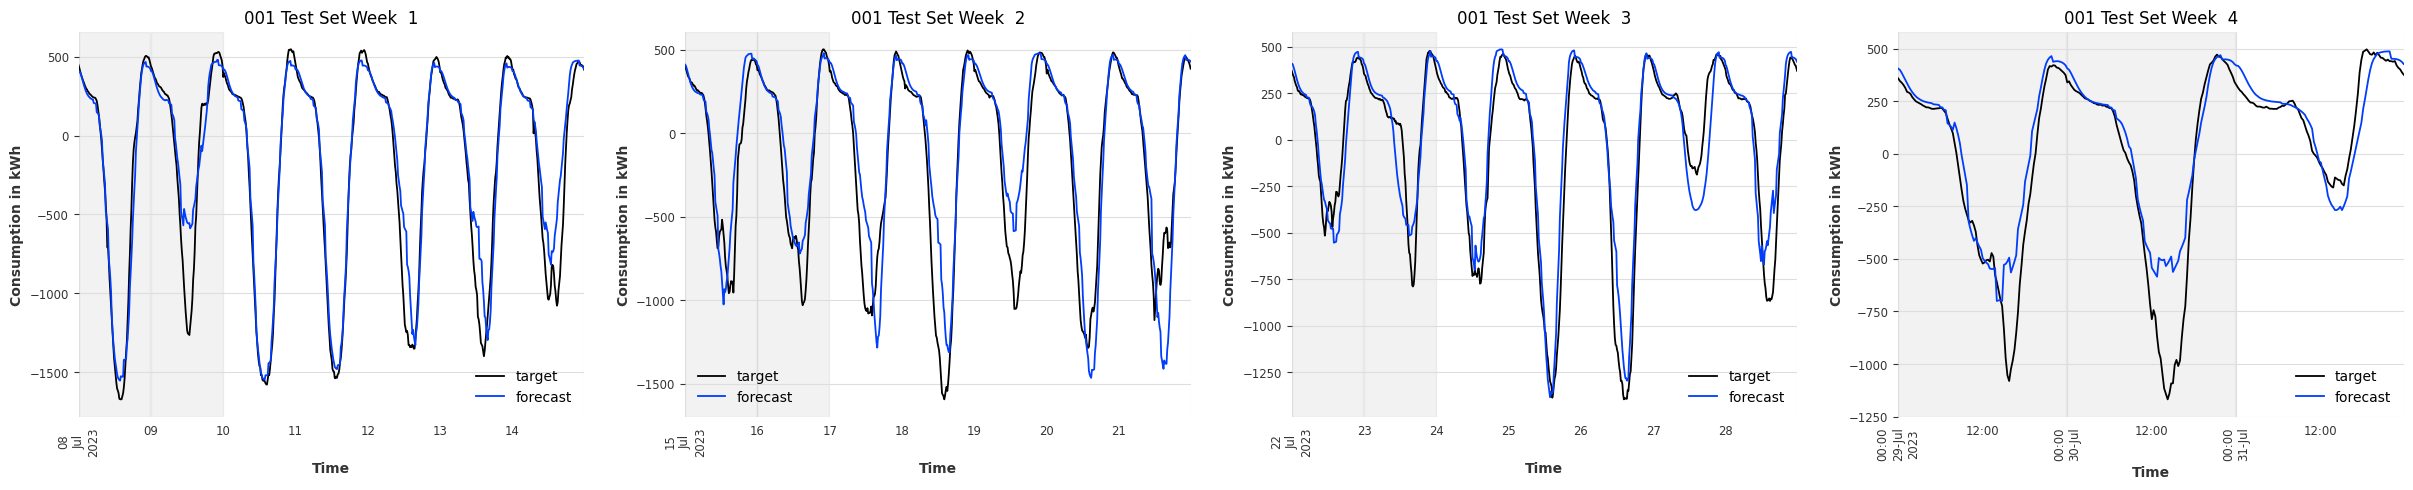

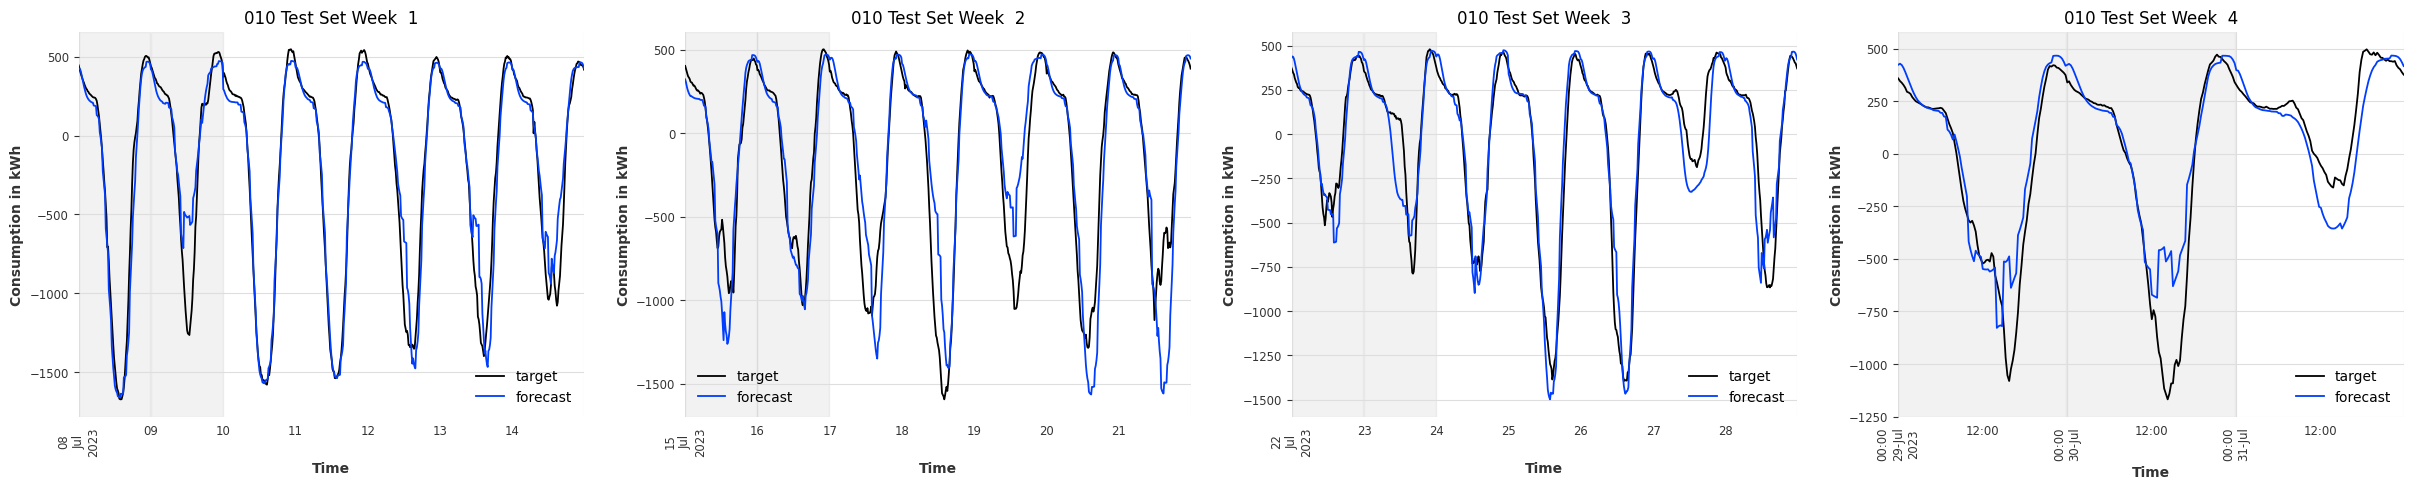

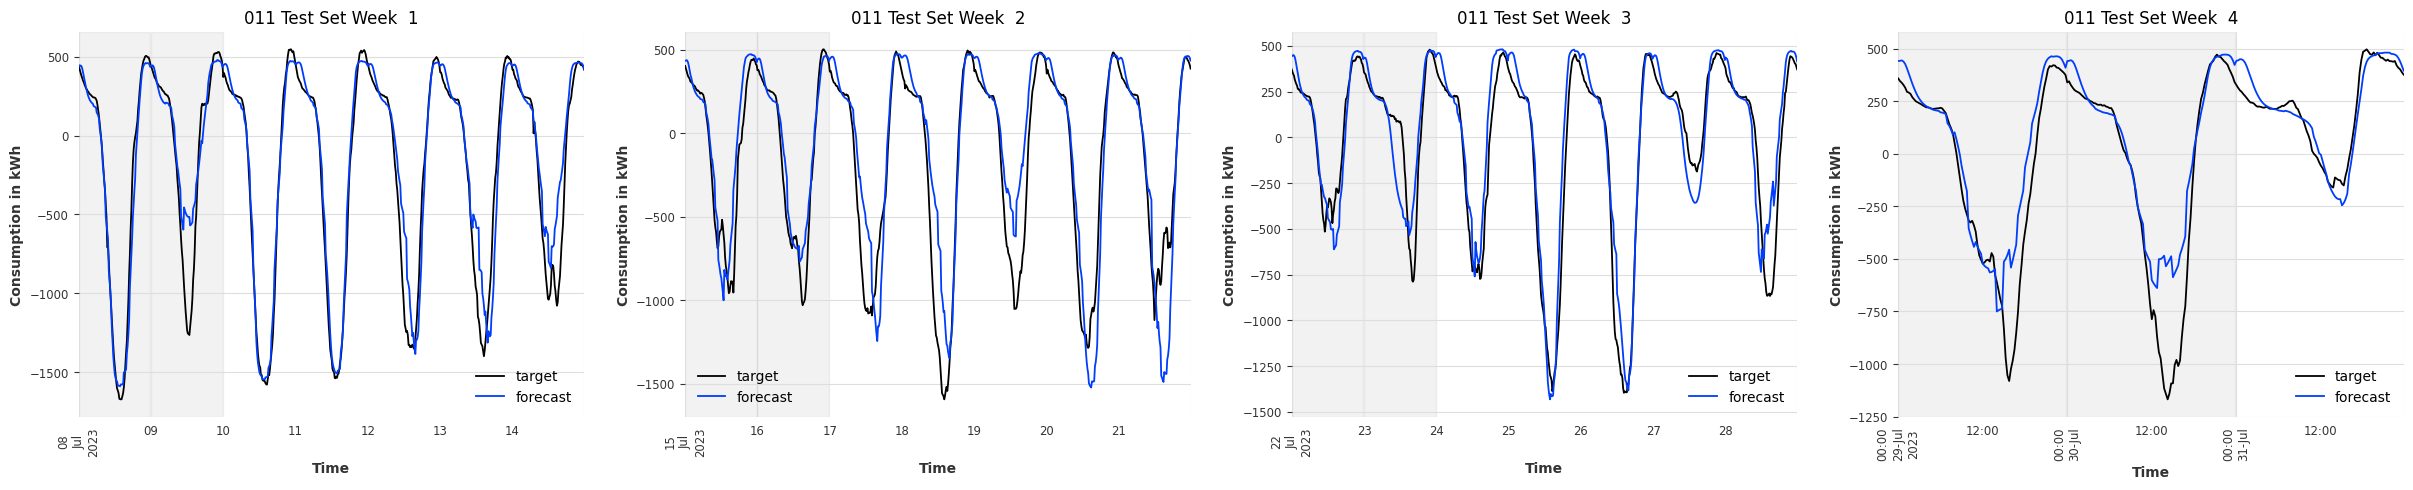

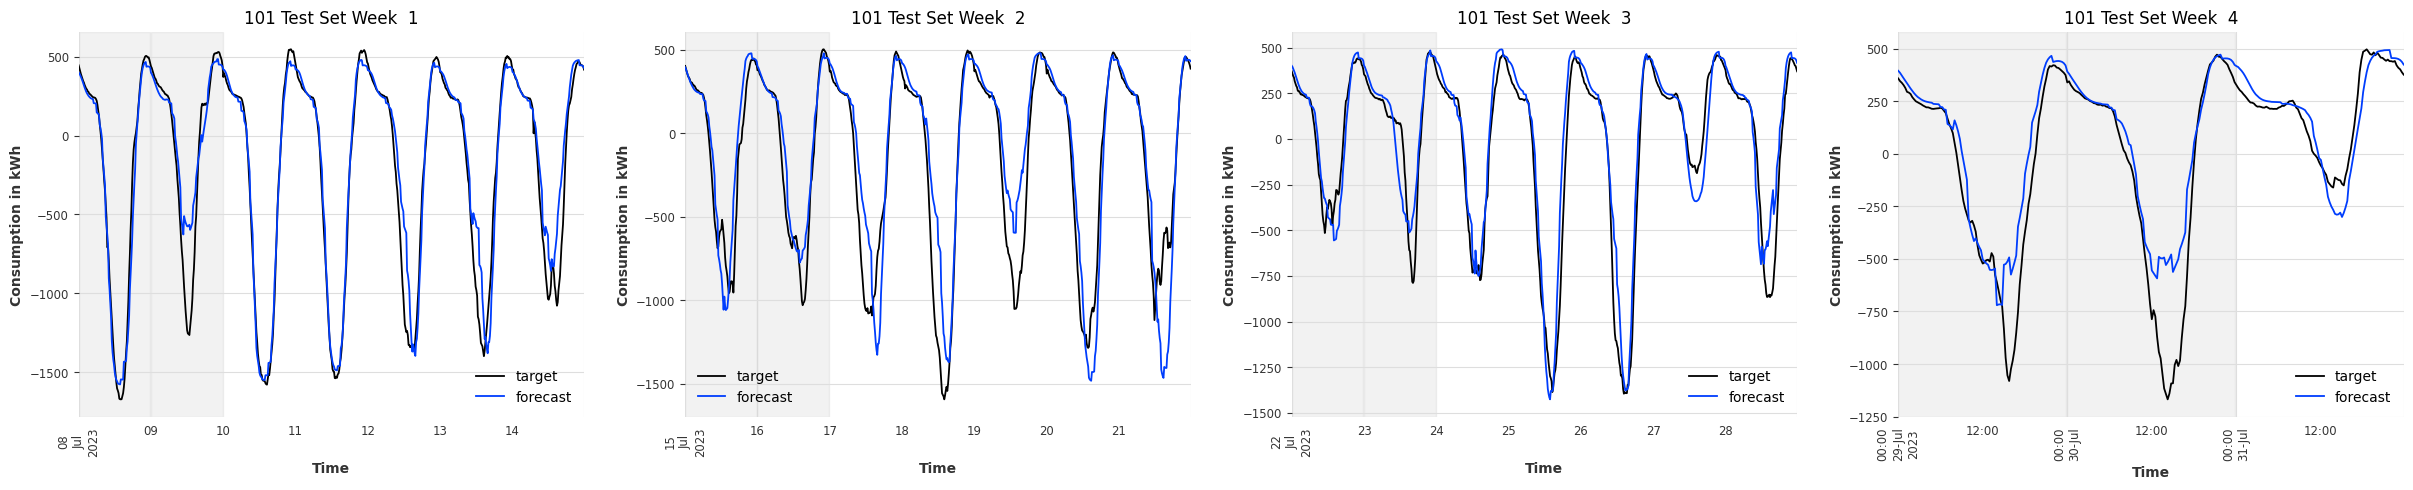

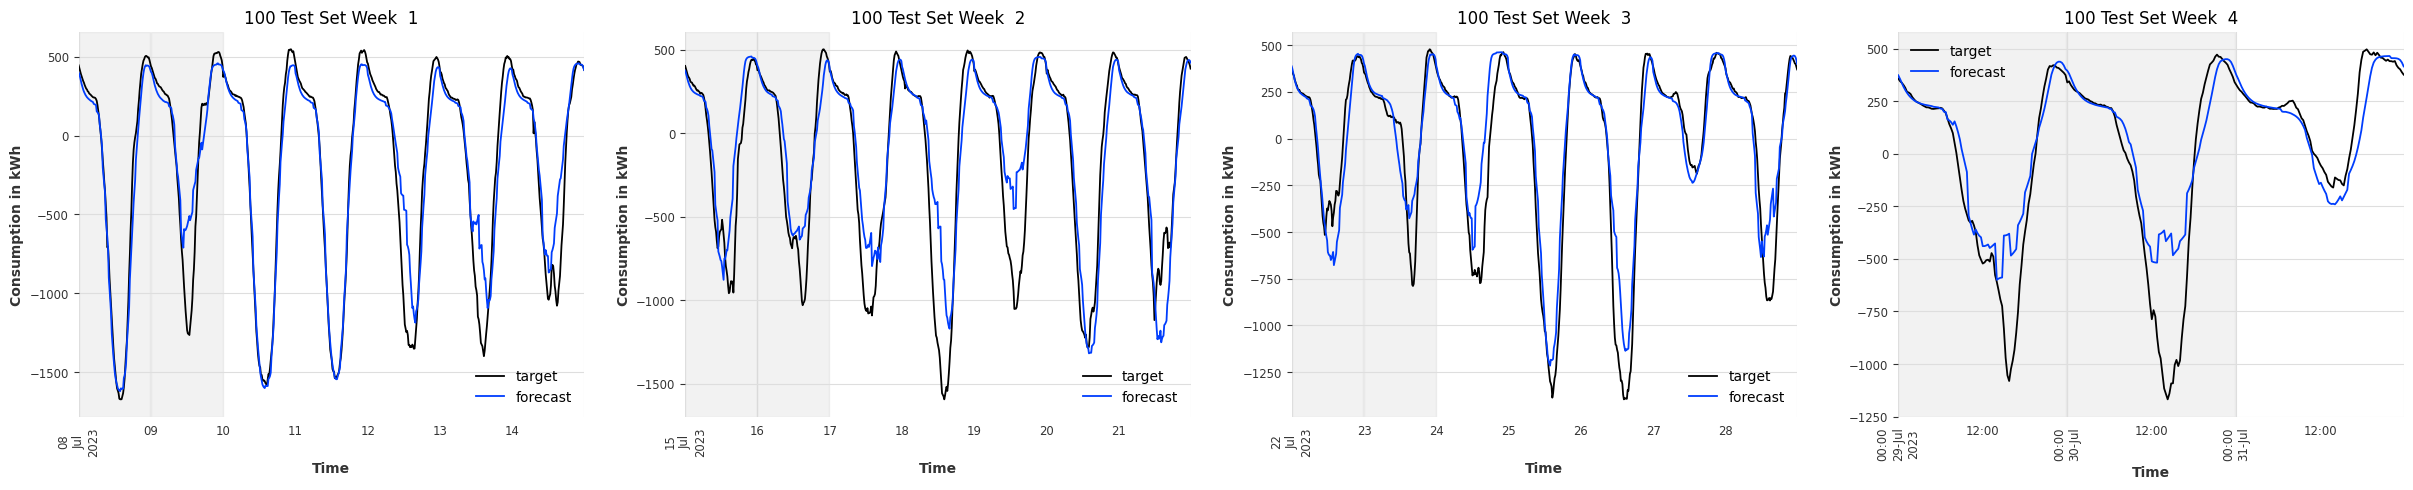

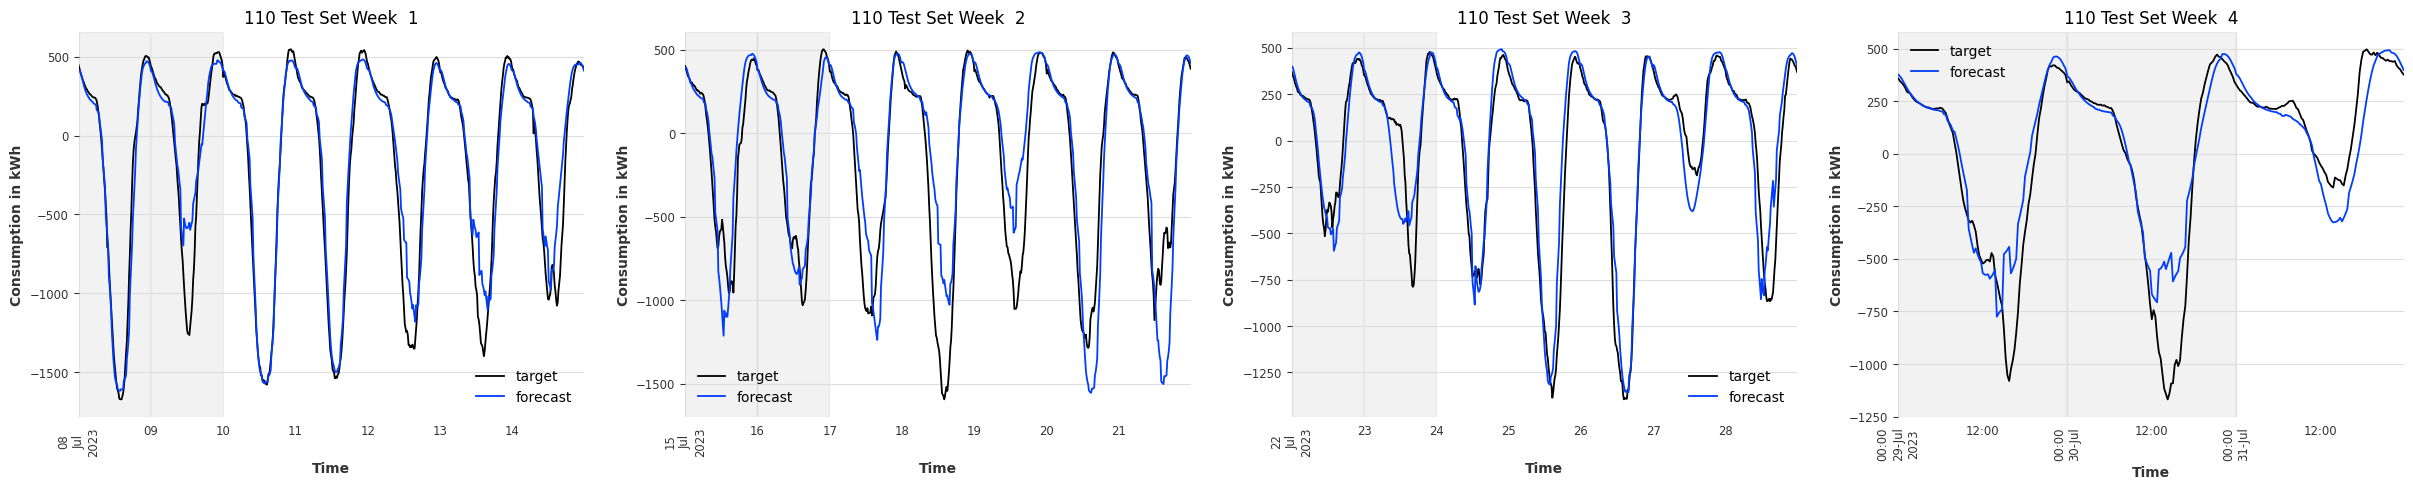

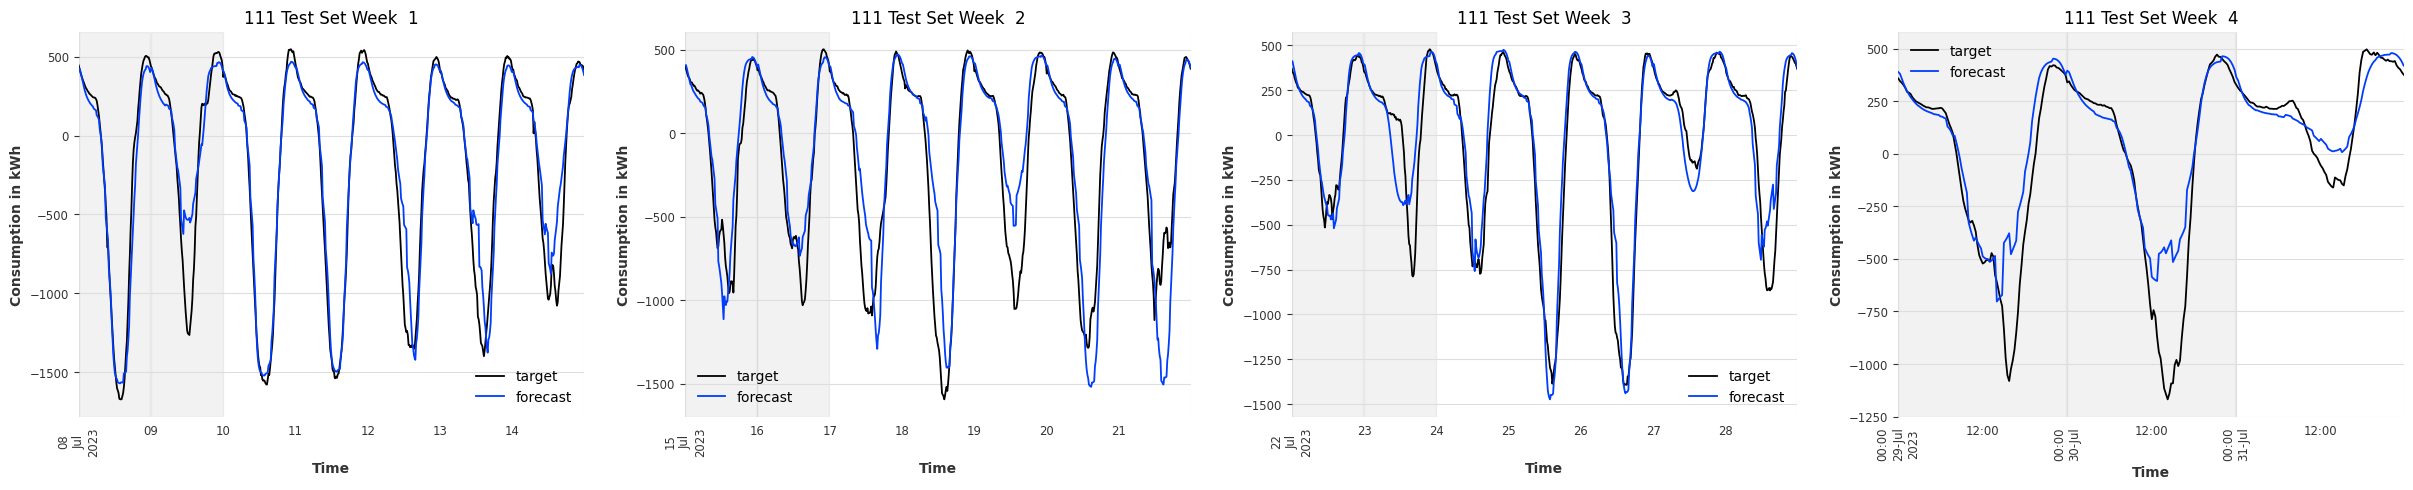

In [289]:
for k,v in model_folders.items():

    test_eval_paths, title = build_paths([test_range], pv_eval, v), f"{k} Test Set Week "
    # train_eval_paths, title = build_paths(train_range, pv_eval, p), "Training Set Week "
    # val_eval_paths, title = build_paths(val_range, pv_eval, p), "Validation Set Week "

    # ggg = [pd.read_csv(j) for j in train_eval_paths]
    # ggg = [pd.read_csv(j) for j in val_eval_paths]
    ggg = [pd.read_csv(j) for j in test_eval_paths]

    def color_in_weekends(_df, _ax, day: int):
        weekend = _df[_df['readingdate'].dt.dayofweek==day]
        _ax.axvspan(weekend['readingdate'].min(), weekend['readingdate'].max(), color='grey', alpha=0.1)


    num_cols = 4
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(30, 5))

    f = ggg[0]
    f = f[['readingdate', 'gross_actuals', 'gross_predicted']].rename(columns={'gross_actuals': 'target', 'gross_predicted': 'forecast'})
    f['target'] = f['target'].apply(lambda x : x/1000)
    f['forecast'] = f['forecast'].apply(lambda x : x/1000)
    f['readingdate'] = pd.to_datetime(f['readingdate'])
    for j in range(0, num_cols):
        subset_f = f.iloc[j*672:(j+1)*672]
        ax = subset_f.set_index('readingdate').plot(title=f"{title} {j+1}", ax=axes[j])
        ax.set_ylabel('Consumption in kWh')
        ax.set_xlabel('Time')
        color_in_weekends(subset_f, ax, 5) # saturday
        color_in_weekends(subset_f, ax, 6) # sunday
        ax.tick_params(axis='x', labelrotation = 90)
    fig.savefig(f'../03_results/images/pv_test_eval_{k}.png')


## Non PV Eval

### Plotting actuals vs predicted nonpv

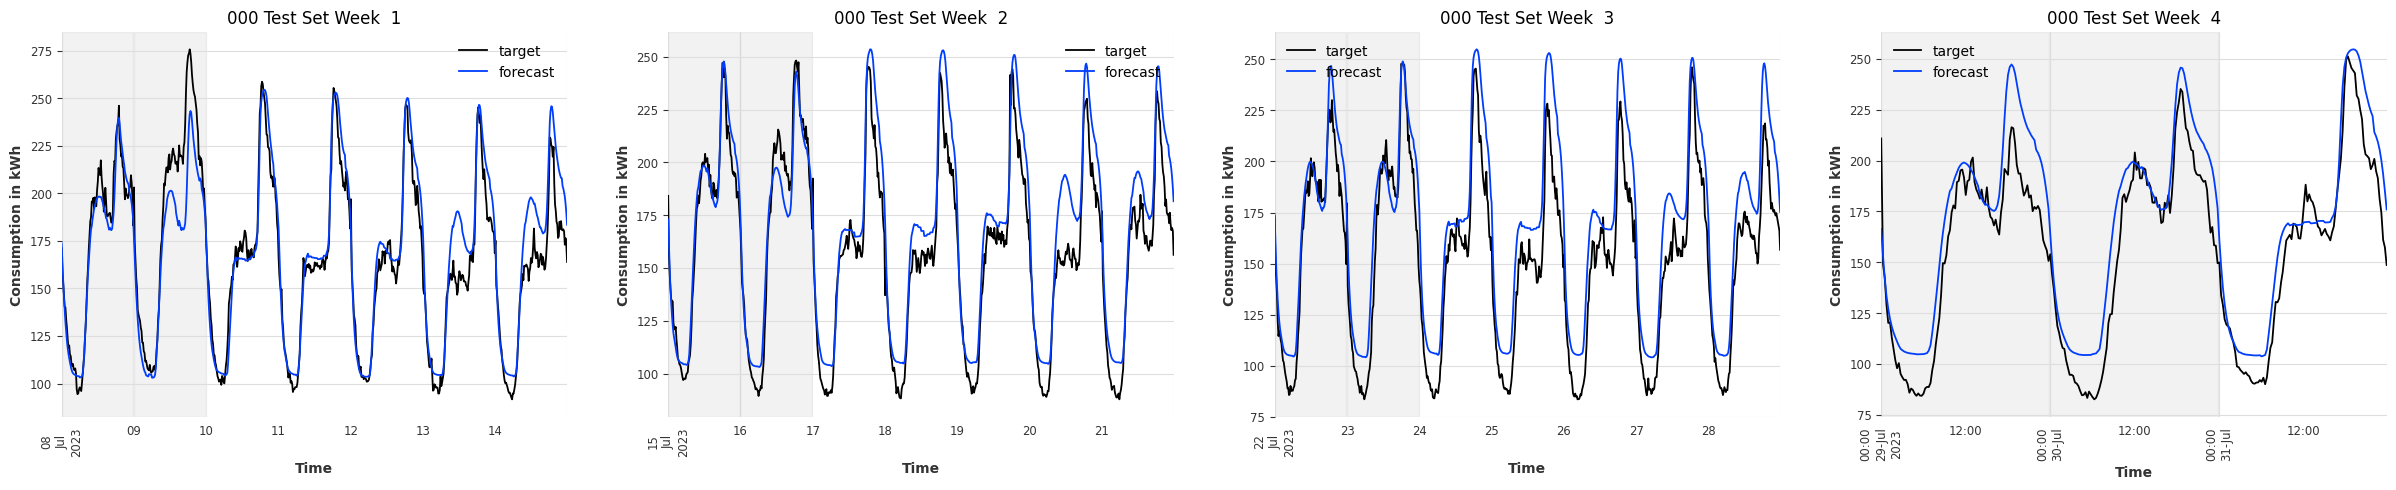

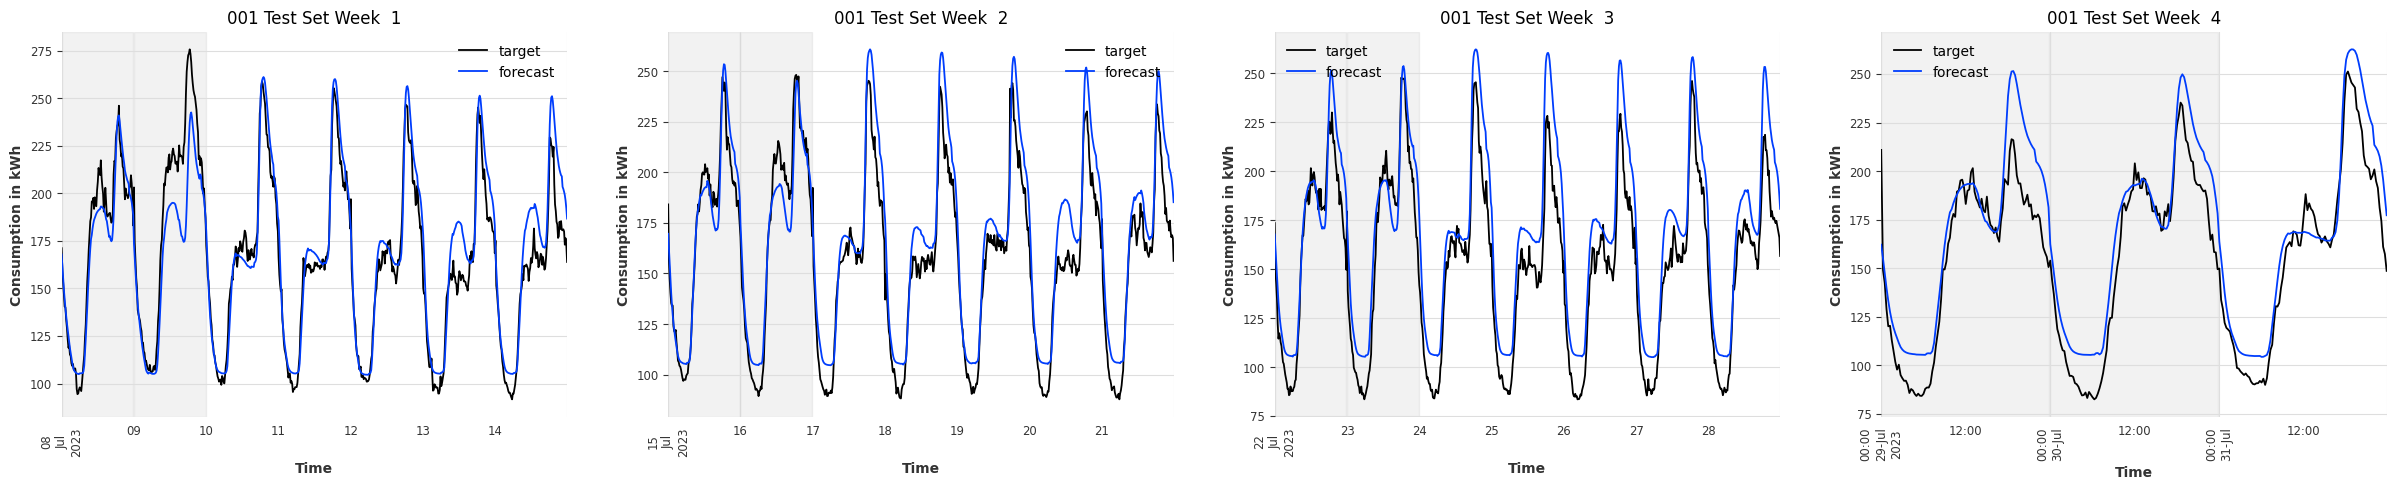

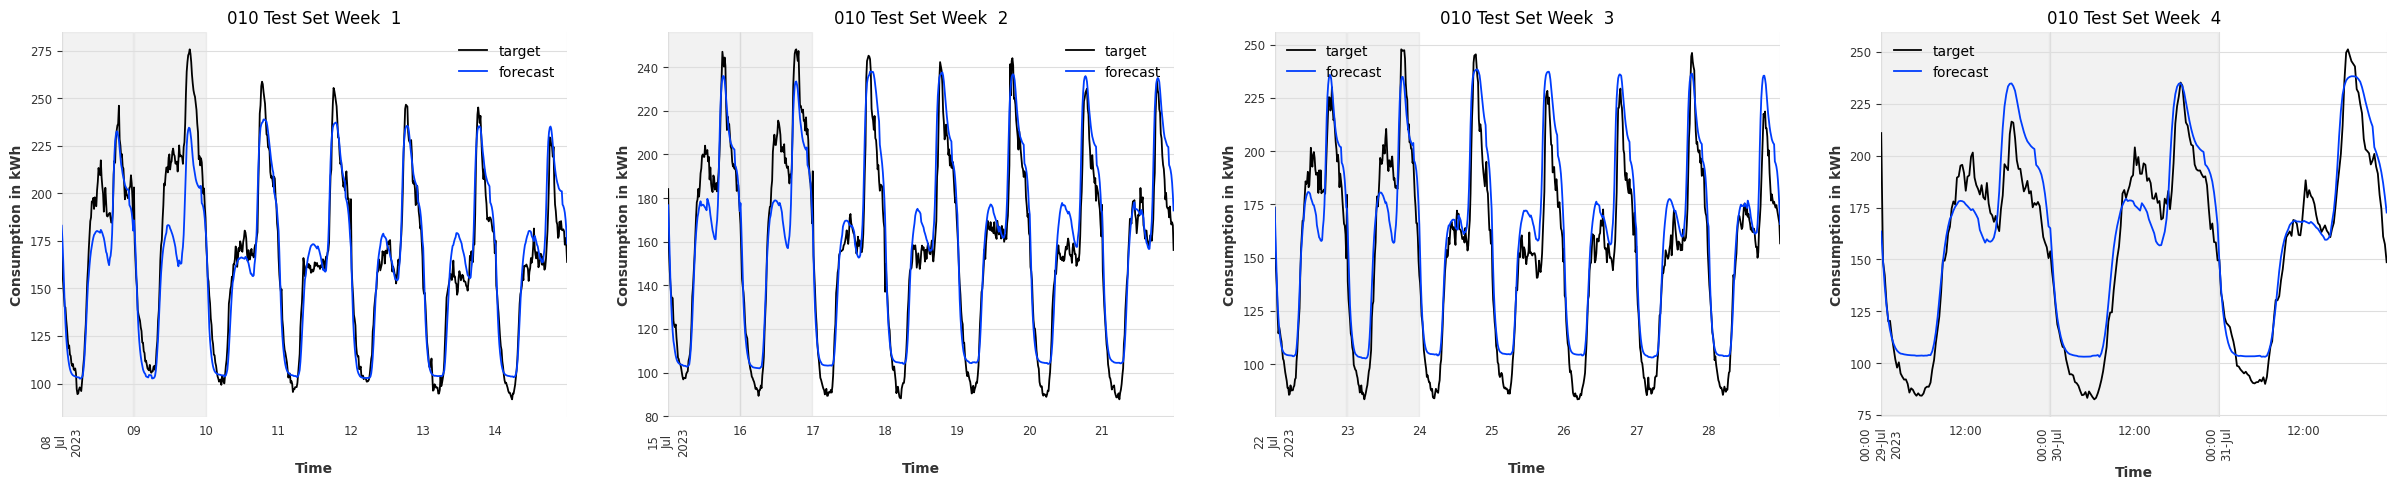

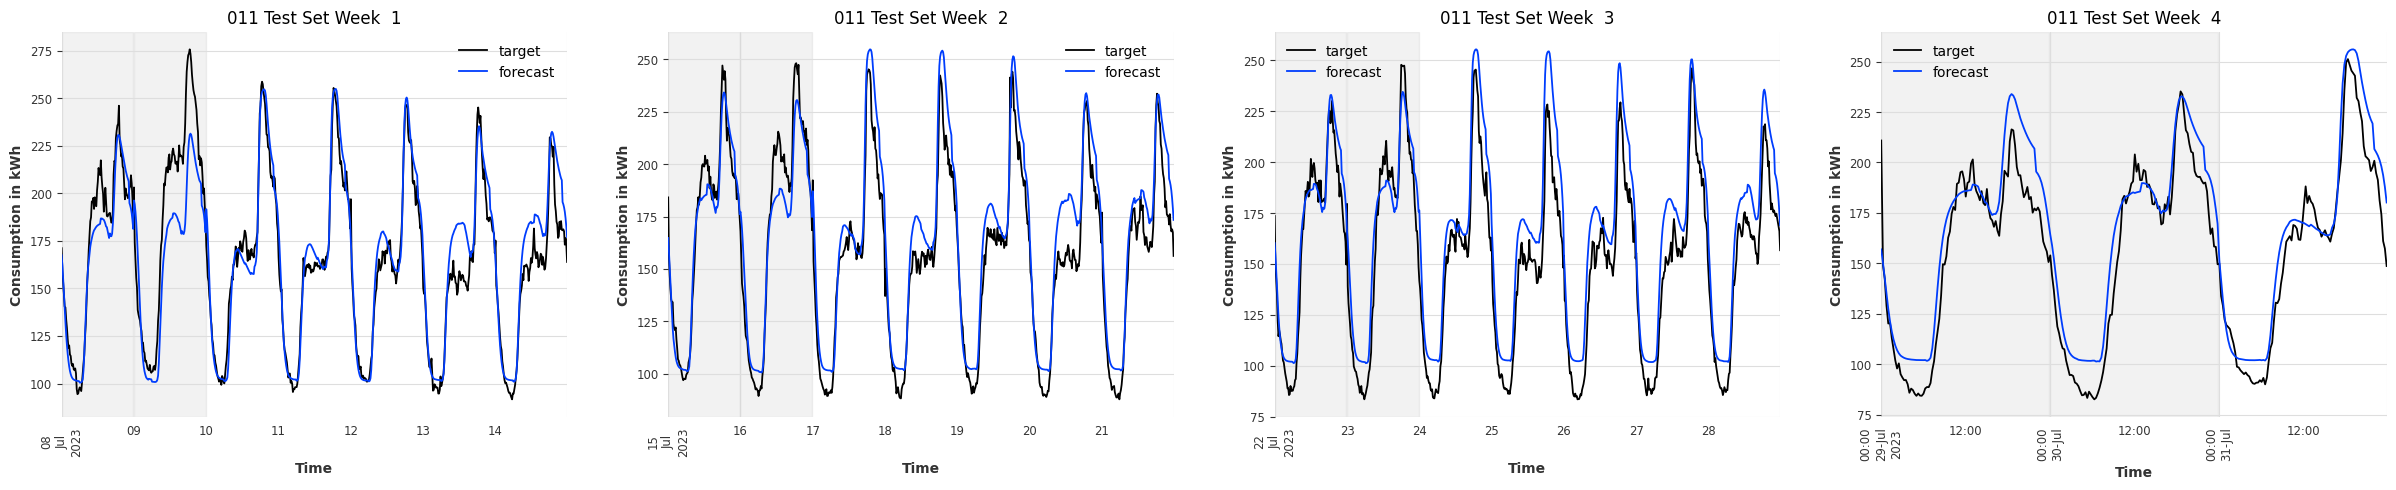

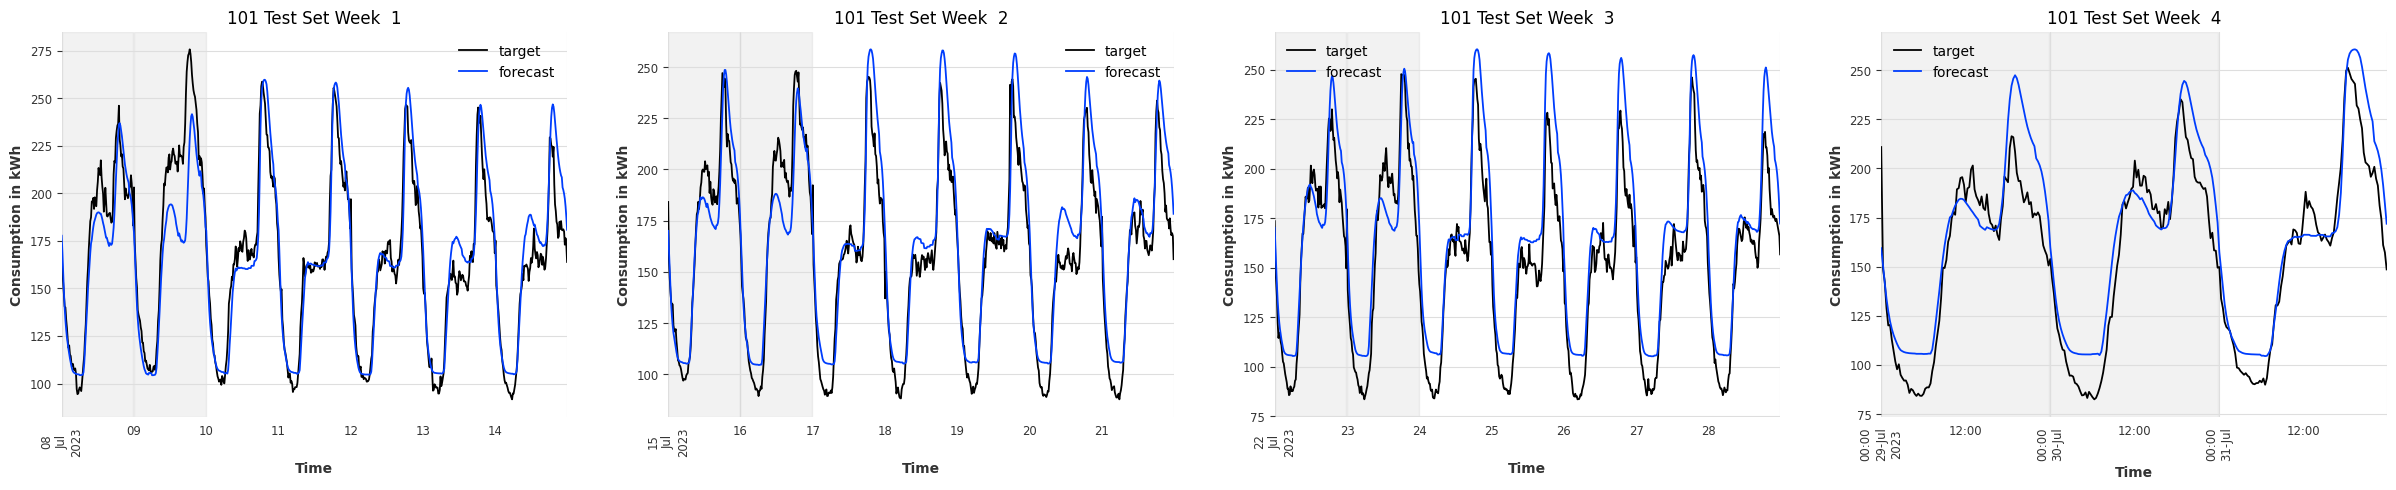

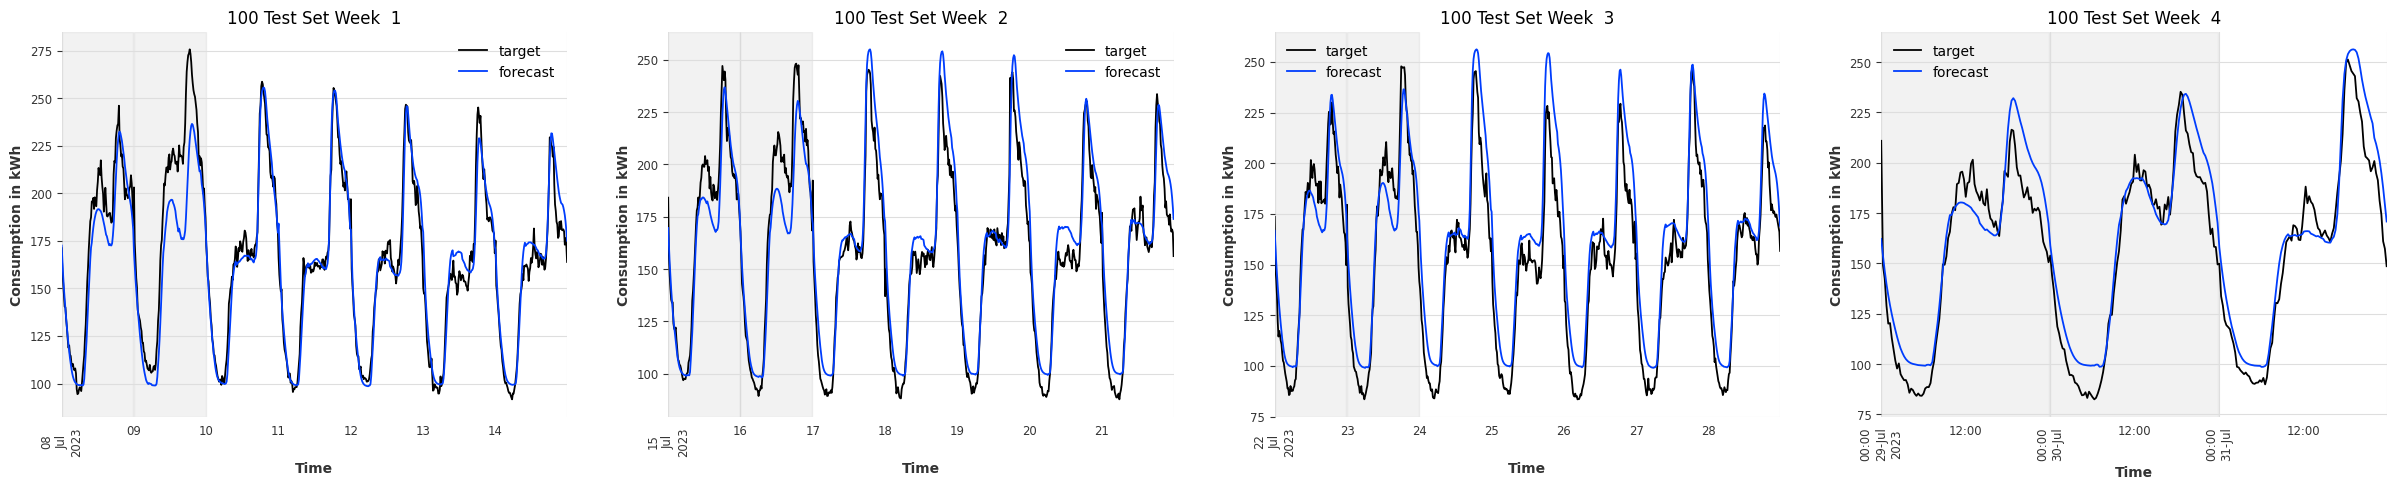

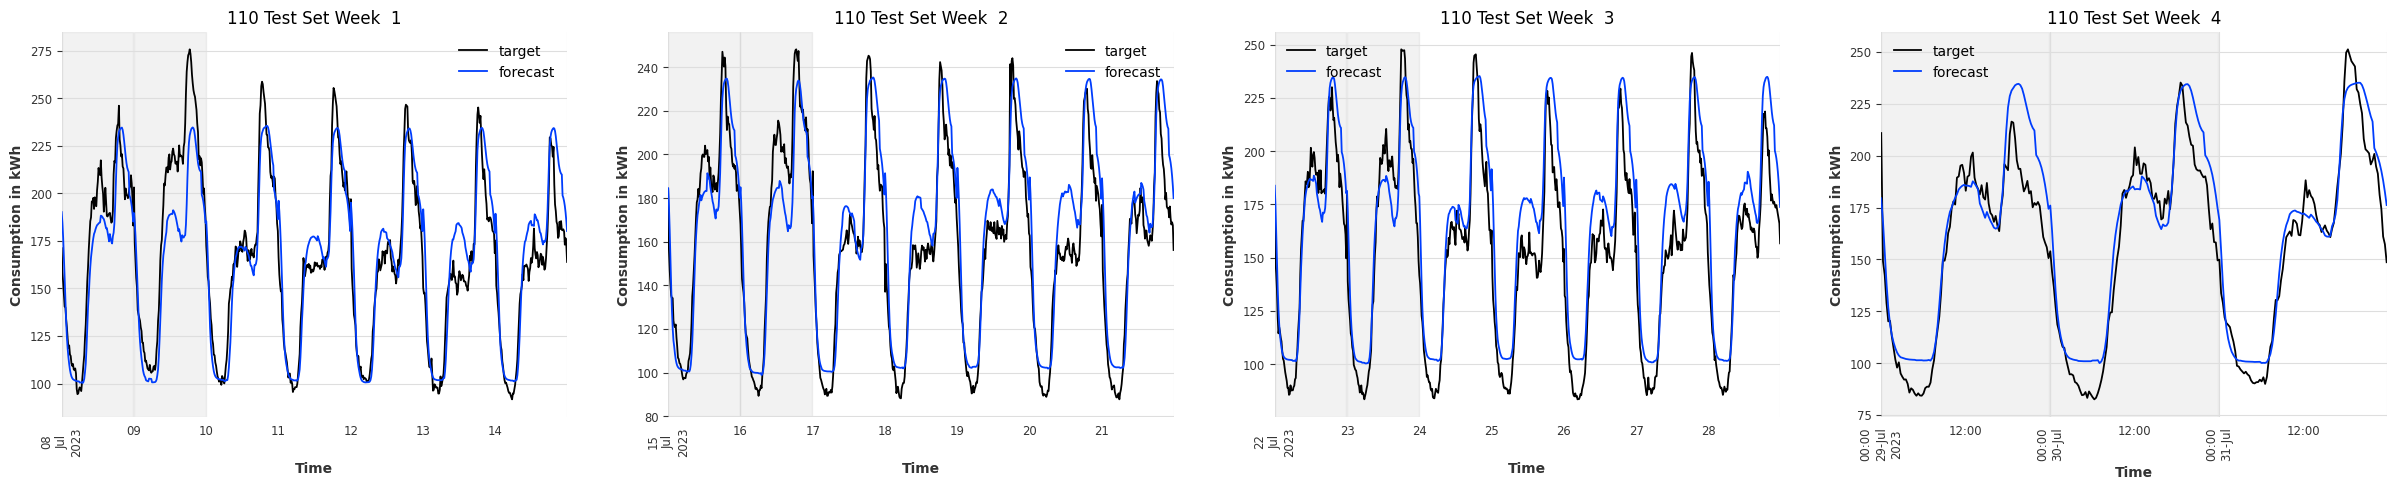

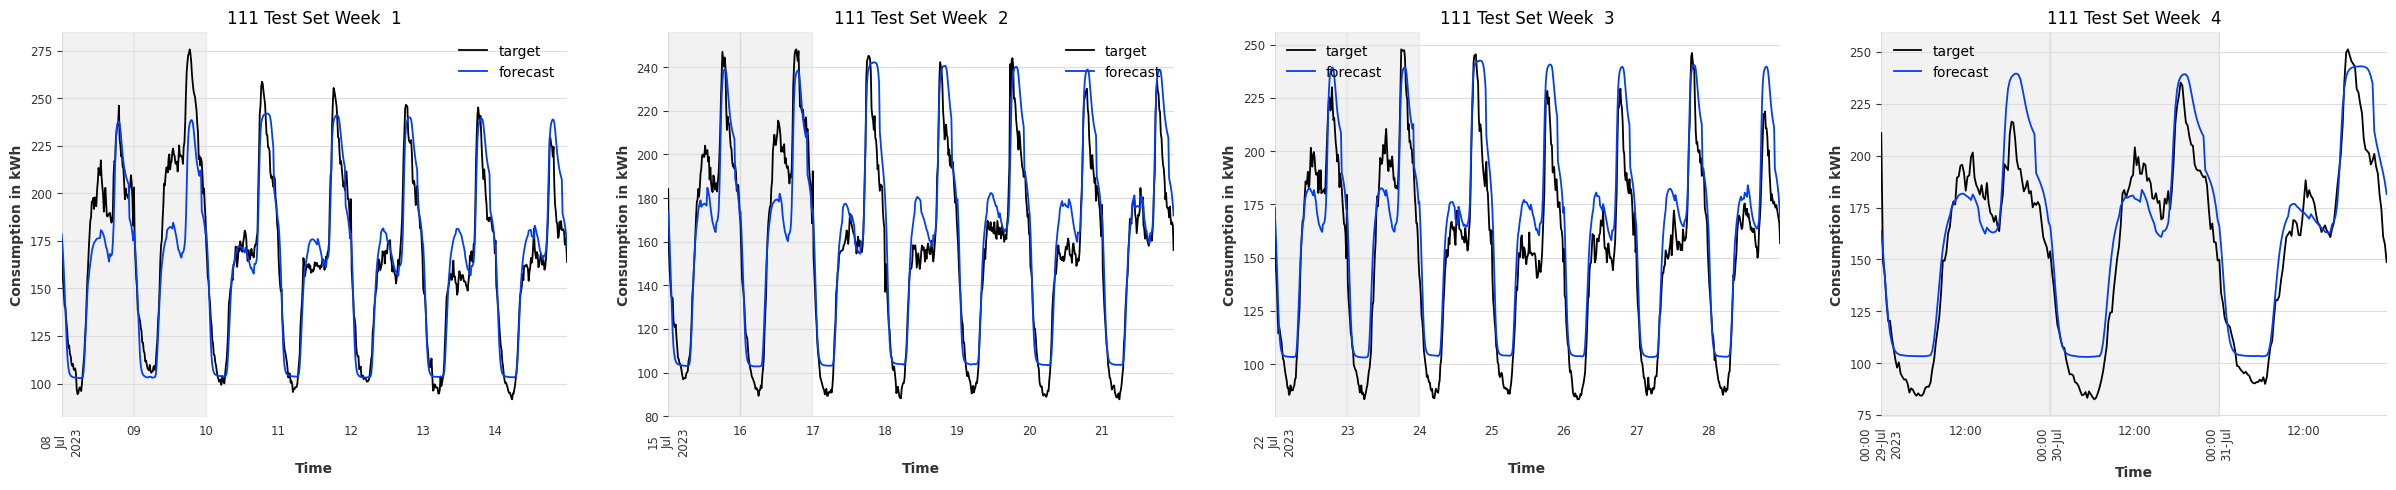

In [271]:
def color_in_weekends(_df, _ax, day: int):
    weekend = _df[_df['readingdate'].dt.dayofweek==day]
    _ax.axvspan(weekend['readingdate'].min(), weekend['readingdate'].max(), color='grey', alpha=0.1)

for k,v in model_folders.items():

    test_eval_paths, title = build_paths([test_range], nonpv_eval, v), f"{k} Test Set Week "
    # train_eval_paths, title = build_paths(train_range, nonpv_eval, v), f"{k} Training Set Week "
    # val_eval_paths, title = build_paths(val_range, nonpv_eval, v), f"{k} Validation Set Week "

    if 'Training' in title:
        ggg = [pd.read_csv(j) for j in train_eval_paths]
        num_cols = 3
        fig_size = (10, 5)
    
    elif 'Validation' in title:
        ggg = [pd.read_csv(j) for j in val_eval_paths]
        num_cols = 2
        fig_size = (10, 5)

    # ggg = [pd.read_csv(j) for j in val_eval_paths]
    else:
        num_cols = 4
        ggg = [pd.read_csv(j) for j in test_eval_paths]
        fig_size = (30, 5)


    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=fig_size)

    f = ggg[0]
    f = f[['readingdate', 'gross_actuals', 'gross_predicted']].rename(columns={'gross_actuals': 'target', 'gross_predicted': 'forecast'})
    f['target'] = f['target'].apply(lambda x : x/1000)
    f['forecast'] = f['forecast'].apply(lambda x : x/1000)
    f['readingdate'] = pd.to_datetime(f['readingdate'])
    for j in range(0, num_cols):
        subset_f = f.iloc[j*672:(j+1)*672]
        ax = subset_f.set_index('readingdate').plot(title=f"{title} {j+1}", ax=axes[j])
        ax.set_ylabel('Consumption in kWh')
        ax.set_xlabel('Time')
        color_in_weekends(subset_f, ax, 5) # saturday
        color_in_weekends(subset_f, ax, 6) # sunday
        ax.tick_params(axis='x', labelrotation = 90)
    
    fig.savefig(f'../03_results/images/non_pv_test_eval_{k}.png')



In [130]:
def get_ts_and_metrics_from(path)-> TimeSeries:
    ts_semantic = TimeSeries.from_csv(f'{path}/2023-07-31_2023-07-08_pv_evaluation_data.csv', time_col='readingdate')
    semantic_metrics = pd.read_csv(f'{path}/2023-07-31_2023-07-08_pv_metrics.csv')
    semantic_metrics.drop(columns='Unnamed: 0', inplace=True)
    return ts_semantic, semantic_metrics

In [135]:
ts_0000, metrics_0000 = get_ts_and_metrics_from( "/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/01_results/20240606_1124_tft_baseline")
ts_0100, metrics_0100 = get_ts_and_metrics_from("/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/01_results/20240607_1941_tft_semantic_0100")
ts_1000, metrics_1000 = get_ts_and_metrics_from("/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/01_results/20240607_1936_tft_semantic_1000")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/01_results/20240607_1936_tft_semantic_1000/2023-07-31_2023-07-08_pv_evaluation_data.csv'

In [128]:
"""
(non finetuned) TFT baseline

        SMAPE 49.273
        MAPE  85.93
        MAE   52130.492
        RMSE  78998.325
        R2    0.84
"""

baseline_metrics.iloc[-1], semantic_metrics.iloc[-1]

(sMAPE           39.763
 MAPE            83.612
 MAE          45419.414
 RMSE          72637.98
 R2               0.871
 Imbalance       28.225
 date              full
 Name: 24, dtype: object,
 sMAPE           40.201
 MAPE            68.637
 MAE          44135.133
 RMSE          68579.87
 R2               0.885
 Imbalance       27.427
 date              full
 Name: 24, dtype: object)

### Plot residuals

### Display Metrics

In [2]:
# TODO concat both train and val sets and recalculate get_metrics()
from neuro_symbolic_demand_forecasting.main_predict import get_metrics


get_metrics

/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.11/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


<function neuro_symbolic_demand_forecasting.main_predict.get_metrics(_target, _predicted)>

## Metrics

In [273]:
list(model_folders.keys())

['000', '001', '010', '011', '101', '100', '110', '111']

In [332]:
def get_percentage(a, b):
    if a < b:
        b, a = a,b
    print(f"{a} -> {b} : ", round(((a - b) / a) * 100, 2))
    return round(((a - b) / a) * 100, 2)

In [336]:
# performance improvements PV peaks
sum([
    get_percentage(62.44, 59.30),
    get_percentage(175.68, 168.4),
    get_percentage(125.05, 118.2),
    get_percentage(176.10, 169),
    get_percentage(0.82, 0.83),
    get_percentage(38.41, 36.31)
]) / 6

62.44 -> 59.3 :  5.03
175.68 -> 168.4 :  4.14
125.05 -> 118.2 :  5.48
176.1 -> 169 :  4.03
0.83 -> 0.82 :  1.2
38.41 -> 36.31 :  5.47


4.225

In [338]:
# perforamnce improvments NON PV - no neg pred
sum([
    get_percentage(8.63, 7.49),
    get_percentage(9.14, 7.67),
    get_percentage(13.72, 11.72),
    get_percentage(16.94, 14.87),
    get_percentage(0.85, 0.89),
    get_percentage(8.64, 7.39)
]) / 6

8.63 -> 7.49 :  13.21
9.14 -> 7.67 :  16.08
13.72 -> 11.72 :  14.58
16.94 -> 14.87 :  12.22
0.89 -> 0.85 :  4.49
8.64 -> 7.39 :  14.47


12.508333333333333

### Full Metrics

In [337]:
AMS_TZ = pytz.timezone('Europe/Amsterdam')
city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
part_of_day_encoder = PartOfDayEncoder(city, AMS_TZ)


selected_range = [test_range]
metrics_df = pd.DataFrame()
for k, v in model_folders.items():

    if k in ['000', '001', '101', '100', '111']:
        eval_paths = build_paths(selected_range, pv_eval, v)
        print(eval_paths)
        ggg = [pd.read_csv(j) for j in eval_paths]
        ggg = pd.concat(ggg)

        ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])

        night_ptus = ggg

        ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
        ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
        metrics = get_metrics(ts, ts1)
        if metrics_df.empty:
            metrics_df = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())]) 
        else:
            ttt = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())])
            metrics_df = pd.concat([metrics_df, ttt])
    # print(k, get_metrics(ts, ts1))

metrics_df = metrics_df.set_index('model')

print()

nonpv_metrics_df = pd.DataFrame()
for k, v in model_folders.items():

    if k in ['000', '001', '010', '011', '101', '100', '110', '111']:
        eval_paths = build_paths(selected_range, nonpv_eval, v)
        print(eval_paths)

        ggg = [pd.read_csv(j) for j in eval_paths]
        ggg = pd.concat(ggg)

        ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])

        night_ptus = ggg

        ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
        ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
        metrics = get_metrics(ts, ts1)
        if nonpv_metrics_df.empty:
            nonpv_metrics_df = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())]) 
        else:
            ttt = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())])
            nonpv_metrics_df = pd.concat([nonpv_metrics_df, ttt])


nonpv_metrics_df = nonpv_metrics_df.set_index('model')

metrics_df['MAE'] = metrics_df['MAE'].apply(lambda x: x/1000)
metrics_df['RMSE'] = metrics_df['RMSE'].apply(lambda x: x/1000)

nonpv_metrics_df['MAE'] = nonpv_metrics_df['MAE'].apply(lambda x: x/1000)
nonpv_metrics_df['RMSE'] = nonpv_metrics_df['RMSE'].apply(lambda x: x/1000)

print() 
# metrics_df
print(metrics_df.to_latex(float_format="%.2f"))
print()

print(nonpv_metrics_df.to_latex(float_format="%.2f"))

['../03_results/20240611_1704_tft_semantic_0000/2023-07-31_2023-07-08_pv_evaluation_data.csv']
['../03_results/20240611_1709_tft_semantic_0010/2023-07-31_2023-07-08_pv_evaluation_data.csv']
['../03_results/20240611_1716_tft_semantic_1010/2023-07-31_2023-07-08_pv_evaluation_data.csv']
['../03_results/20240611_1717_tft_semantic_1000/2023-07-31_2023-07-08_pv_evaluation_data.csv']
['../03_results/20240611_1720_tft_semantic_1110/2023-07-31_2023-07-08_pv_evaluation_data.csv']

['../03_results/20240611_1704_tft_semantic_0000/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']
['../03_results/20240611_1709_tft_semantic_0010/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']
['../03_results/20240611_1709_tft_semantic_0100/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']
['../03_results/20240611_1716_tft_semantic_0110/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']
['../03_results/20240611_1716_tft_semantic_1010/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']
['../03_results/20240611_1717

### Display Metrics for no negative predictions at night

In [294]:
AMS_TZ = pytz.timezone('Europe/Amsterdam')
city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
part_of_day_encoder = PartOfDayEncoder(city, AMS_TZ)


selected_range = [test_range]
metrics_df = pd.DataFrame()
for k, v in model_folders.items():

    if k in ['000', '100']:
        eval_paths = build_paths(selected_range, pv_eval, v)
        print(eval_paths)
        ggg = [pd.read_csv(j) for j in eval_paths]
        
        ggg = pd.concat(ggg)

        ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])
        ggg['part_of_day'] = part_of_day_encoder.encode(ggg['readingdate'])

        night_ptus = ggg[ggg['part_of_day'] == 0.0]

        ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
        ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
        metrics = get_metrics(ts, ts1)
        if metrics_df.empty:
            metrics_df = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())]) 
        else:
            ttt = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())])
            metrics_df = pd.concat([metrics_df, ttt])
    # print(k, get_metrics(ts, ts1))

metrics_df = metrics_df.set_index('model')

print()

nonpv_metrics_df = pd.DataFrame()
for k, v in model_folders.items():

    if k in ['000', '100']:
        eval_paths = build_paths(selected_range, nonpv_eval, v)
        print(eval_paths)

        ggg = [pd.read_csv(j) for j in eval_paths]
        
        ggg = pd.concat(ggg)

        ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])
        ggg['part_of_day'] = part_of_day_encoder.encode(ggg['readingdate'])

        night_ptus = ggg[ggg['part_of_day'] == 0.0]

        ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
        ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
        metrics = get_metrics(ts, ts1)
        if nonpv_metrics_df.empty:
            nonpv_metrics_df = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())]) 
        else:
            ttt = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())])
            nonpv_metrics_df = pd.concat([nonpv_metrics_df, ttt])


nonpv_metrics_df = nonpv_metrics_df.set_index('model')

metrics_df['MAE'] = metrics_df['MAE'].apply(lambda x: x/1000)
metrics_df['RMSE'] = metrics_df['RMSE'].apply(lambda x: x/1000)

nonpv_metrics_df['MAE'] = nonpv_metrics_df['MAE'].apply(lambda x: x/1000)
nonpv_metrics_df['RMSE'] = nonpv_metrics_df['RMSE'].apply(lambda x: x/1000)

print() 
# metrics_df
print(metrics_df.to_latex(float_format="%.2f"))
print()

print(nonpv_metrics_df.to_latex(float_format="%.2f"))

['../03_results/20240611_1704_tft_semantic_0000/2023-07-31_2023-07-08_pv_evaluation_data.csv']
['../03_results/20240611_1717_tft_semantic_1000/2023-07-31_2023-07-08_pv_evaluation_data.csv']

['../03_results/20240611_1704_tft_semantic_0000/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']
['../03_results/20240611_1717_tft_semantic_1000/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']

\begin{tabular}{lrrrrrr}
\toprule
 & sMAPE & MAPE & MAE & RMSE & R2 & Imbalance \\
model &  &  &  &  &  &  \\
\midrule
000 & 7.63 & 7.95 & 25.15 & 31.95 & 0.86 & 7.96 \\
100 & 8.13 & 7.76 & 25.22 & 32.46 & 0.86 & 7.98 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
 & sMAPE & MAPE & MAE & RMSE & R2 & Imbalance \\
model &  &  &  &  &  &  \\
\midrule
000 & 9.56 & 10.20 & 12.12 & 14.65 & 0.83 & 9.71 \\
100 & 8.47 & 8.95 & 10.67 & 12.75 & 0.87 & 8.54 \\
\bottomrule
\end{tabular}



### Metrics for Peaks

In [295]:
AMS_TZ = pytz.timezone('Europe/Amsterdam')
city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
part_of_day_encoder = PartOfDayEncoder(city, AMS_TZ)

print(list(model_folders.keys()))
keys = ['000', '001']

selected_range = [test_range]
metrics_df = pd.DataFrame()
for k, v in model_folders.items():

    if k in keys:
        eval_paths = build_paths(selected_range, pv_eval, v)
        print(eval_paths)
        ggg = [pd.read_csv(j) for j in eval_paths]
        
        ggg = pd.concat(ggg)

        ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])
        ggg['part_of_day'] = part_of_day_encoder.encode(ggg['readingdate'])

        night_ptus = ggg[(ggg['part_of_day'] == 0.25) | (ggg['part_of_day'] == 1.0)]

        ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
        ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
        metrics = get_metrics(ts, ts1)
        if metrics_df.empty:
            metrics_df = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())]) 
        else:
            ttt = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())])
            metrics_df = pd.concat([metrics_df, ttt])

metrics_df = metrics_df.set_index('model')

print() 

nonpv_metrics_df = pd.DataFrame()
for k, v in model_folders.items():

    if k in keys:
        eval_paths = build_paths(selected_range, nonpv_eval, v)
        print(eval_paths)

        ggg = [pd.read_csv(j) for j in eval_paths]
        
        ggg = pd.concat(ggg)

        ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])
        ggg['part_of_day'] = part_of_day_encoder.encode(ggg['readingdate'])

        night_ptus = ggg[(ggg['part_of_day'] == 0.25) | (ggg['part_of_day'] == 1.0)]

        ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
        ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
        metrics = get_metrics(ts, ts1)
        if nonpv_metrics_df.empty:
            nonpv_metrics_df = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())]) 
        else:
            ttt = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())])
            nonpv_metrics_df = pd.concat([nonpv_metrics_df, ttt])

nonpv_metrics_df = nonpv_metrics_df.set_index('model')

metrics_df['MAE'] = metrics_df['MAE'].apply(lambda x: x/1000)
metrics_df['RMSE'] = metrics_df['RMSE'].apply(lambda x: x/1000)

nonpv_metrics_df['MAE'] = nonpv_metrics_df['MAE'].apply(lambda x: x/1000)
nonpv_metrics_df['RMSE'] = nonpv_metrics_df['RMSE'].apply(lambda x: x/1000)


print() 
# metrics_df
print(metrics_df.to_latex(float_format="%.2f"))
print() 
print(nonpv_metrics_df.to_latex(float_format="%.2f"))

['000', '001', '010', '011', '101', '100', '110', '111']
['../03_results/20240611_1704_tft_semantic_0000/2023-07-31_2023-07-08_pv_evaluation_data.csv']
['../03_results/20240611_1709_tft_semantic_0010/2023-07-31_2023-07-08_pv_evaluation_data.csv']

['../03_results/20240611_1704_tft_semantic_0000/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']
['../03_results/20240611_1709_tft_semantic_0010/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']

\begin{tabular}{lrrrrrr}
\toprule
 & sMAPE & MAPE & MAE & RMSE & R2 & Imbalance \\
model &  &  &  &  &  &  \\
\midrule
000 & 62.44 & 175.68 & 125.05 & 176.10 & 0.82 & 38.41 \\
001 & 59.30 & 168.35 & 118.23 & 169.01 & 0.83 & 36.31 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
 & sMAPE & MAPE & MAE & RMSE & R2 & Imbalance \\
model &  &  &  &  &  &  \\
\midrule
000 & 8.83 & 9.35 & 15.79 & 19.26 & 0.82 & 8.91 \\
001 & 8.35 & 8.73 & 15.36 & 19.07 & 0.82 & 8.67 \\
\bottomrule
\end{tabular}



### Metrics for non neg pred nonpv

In [296]:
AMS_TZ = pytz.timezone('Europe/Amsterdam')
city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
part_of_day_encoder = PartOfDayEncoder(city, AMS_TZ)

print(list(model_folders.keys()))
keys = ['000', '010']

selected_range = [test_range]
metrics_df = pd.DataFrame()
for k, v in model_folders.items():

    if k in keys:
        eval_paths = build_paths(selected_range, pv_eval, v)
        print(eval_paths)
        ggg = [pd.read_csv(j) for j in eval_paths]
        
        ggg = pd.concat(ggg)

        ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])
        ggg['part_of_day'] = part_of_day_encoder.encode(ggg['readingdate'])

        night_ptus = ggg

        ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
        ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
        metrics = get_metrics(ts, ts1)
        if metrics_df.empty:
            metrics_df = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())]) 
        else:
            ttt = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())])
            metrics_df = pd.concat([metrics_df, ttt])
    # print(k, get_metrics(ts, ts1))

metrics_df = metrics_df.set_index('model')

print()

nonpv_metrics_df = pd.DataFrame()
for k, v in model_folders.items():

    if k in keys:
        eval_paths = build_paths(selected_range, nonpv_eval, v)
        print(eval_paths)

        ggg = [pd.read_csv(j) for j in eval_paths]
        
        ggg = pd.concat(ggg)

        ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])
        ggg['part_of_day'] = part_of_day_encoder.encode(ggg['readingdate'])

        night_ptus = ggg

        ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
        ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
        metrics = get_metrics(ts, ts1)
        if nonpv_metrics_df.empty:
            nonpv_metrics_df = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())]) 
        else:
            ttt = pd.DataFrame(columns=['model'] + list(metrics.keys()), data=[[k] + list(metrics.values())])
            nonpv_metrics_df = pd.concat([nonpv_metrics_df, ttt])


nonpv_metrics_df = nonpv_metrics_df.set_index('model')

metrics_df['MAE'] = metrics_df['MAE'].apply(lambda x: x/1000)
metrics_df['RMSE'] = metrics_df['RMSE'].apply(lambda x: x/1000)

nonpv_metrics_df['MAE'] = nonpv_metrics_df['MAE'].apply(lambda x: x/1000)
nonpv_metrics_df['RMSE'] = nonpv_metrics_df['RMSE'].apply(lambda x: x/1000)

print() 
# metrics_df
print(metrics_df.to_latex(float_format="%.2f"))
print()

print(nonpv_metrics_df.to_latex(float_format="%.2f"))

['000', '001', '010', '011', '101', '100', '110', '111']
['../03_results/20240611_1704_tft_semantic_0000/2023-07-31_2023-07-08_pv_evaluation_data.csv']
['../03_results/20240611_1709_tft_semantic_0100/2023-07-31_2023-07-08_pv_evaluation_data.csv']

['../03_results/20240611_1704_tft_semantic_0000/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']
['../03_results/20240611_1709_tft_semantic_0100/2023-07-31_2023-07-08_non_pv_evaluation_data.csv']

\begin{tabular}{lrrrrrr}
\toprule
 & sMAPE & MAPE & MAE & RMSE & R2 & Imbalance \\
model &  &  &  &  &  &  \\
\midrule
000 & 38.53 & 141.19 & 116.42 & 185.22 & 0.89 & 25.68 \\
010 & 35.56 & 198.09 & 114.17 & 187.38 & 0.89 & 25.18 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrrr}
\toprule
 & sMAPE & MAPE & MAE & RMSE & R2 & Imbalance \\
model &  &  &  &  &  &  \\
\midrule
000 & 8.63 & 9.14 & 13.72 & 16.94 & 0.85 & 8.64 \\
010 & 7.49 & 7.67 & 11.72 & 14.87 & 0.89 & 7.39 \\
\bottomrule
\end{tabular}



In [288]:
AMS_TZ = pytz.timezone('Europe/Amsterdam')
city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
part_of_day_encoder = PartOfDayEncoder(city, AMS_TZ)

for k, v in model_folders.items():

    # train_eval_paths = build_paths(train_range, pv_eval, v)
    # ggg = [pd.read_csv(j) for j in train_eval_paths]

    test_eval_paths = build_paths([test_range], pv_eval, v)
    ggg = [pd.read_csv(j) for j in test_eval_paths]

    # val_eval_paths = build_paths(val_range, pv_eval, v)
    # ggg = [pd.read_csv(j) for j in val_eval_paths]
    
    ggg = pd.concat(ggg)

    ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])
    ggg['part_of_day'] = part_of_day_encoder.encode(ggg['readingdate'])

    night_ptus = ggg[ggg['part_of_day'] == 0.0]

    ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
    ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
    print(k, get_metrics(ts, ts1))

000 {'sMAPE': 7.632, 'MAPE': 7.954, 'MAE': 25149.534, 'RMSE': 31954.232, 'R2': 0.863, 'Imbalance': 7.962}
001 {'sMAPE': 8.582, 'MAPE': 8.945, 'MAE': 27661.84, 'RMSE': 34911.51, 'R2': 0.837, 'Imbalance': 8.757}
010 {'sMAPE': 10.632, 'MAPE': 10.505, 'MAE': 32784.405, 'RMSE': 41441.298, 'R2': 0.77, 'Imbalance': 10.379}
011 {'sMAPE': 13.556, 'MAPE': 14.831, 'MAE': 45725.016, 'RMSE': 60141.297, 'R2': 0.516, 'Imbalance': 14.475}
101 {'sMAPE': 8.884, 'MAPE': 9.293, 'MAE': 28630.698, 'RMSE': 36031.067, 'R2': 0.826, 'Imbalance': 9.064}
100 {'sMAPE': 8.128, 'MAPE': 7.763, 'MAE': 25220.059, 'RMSE': 32461.37, 'R2': 0.859, 'Imbalance': 7.984}
110 {'sMAPE': 7.057, 'MAPE': 7.025, 'MAE': 22040.901, 'RMSE': 27535.439, 'R2': 0.899, 'Imbalance': 6.977}
111 {'sMAPE': 10.305, 'MAPE': 9.695, 'MAE': 28291.183, 'RMSE': 33635.491, 'R2': 0.849, 'Imbalance': 8.956}


In [287]:
AMS_TZ = pytz.timezone('Europe/Amsterdam')
city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
part_of_day_encoder = PartOfDayEncoder(city, AMS_TZ)

for k, v in model_folders.items():

    # train_eval_paths = build_paths(train_range, pv_eval, v)
    # ggg = [pd.read_csv(j) for j in train_eval_paths]

    # test_eval_paths = build_paths([test_range], pv_eval, v)
    # ggg = [pd.read_csv(j) for j in test_eval_paths]

    val_eval_paths = build_paths(val_range, pv_eval, v)
    ggg = [pd.read_csv(j) for j in val_eval_paths]
    
    ggg = pd.concat(ggg)

    ggg['readingdate'] = pd.to_datetime(ggg['readingdate'])
    ggg['part_of_day'] = part_of_day_encoder.encode(ggg['readingdate'])

    night_ptus = ggg[(ggg['part_of_day'] == 0.25) | (ggg['part_of_day'] == 1)]

    ts = TimeSeries.from_values(night_ptus['gross_actuals'].values)
    ts1 = TimeSeries.from_values(night_ptus['gross_predicted'].values)
    print(k, get_metrics(ts, ts1))

000 {'sMAPE': 41.745, 'MAPE': 103.521, 'MAE': 64220.647, 'RMSE': 97490.153, 'R2': 0.93, 'Imbalance': 21.919}
001 {'sMAPE': 42.929, 'MAPE': 102.487, 'MAE': 64230.555, 'RMSE': 92102.606, 'R2': 0.938, 'Imbalance': 21.922}
010 {'sMAPE': 40.694, 'MAPE': 96.238, 'MAE': 60198.081, 'RMSE': 84580.624, 'R2': 0.948, 'Imbalance': 20.546}
011 {'sMAPE': 38.194, 'MAPE': 94.732, 'MAE': 56635.469, 'RMSE': 83762.086, 'R2': 0.949, 'Imbalance': 19.33}
101 {'sMAPE': 38.91, 'MAPE': 93.599, 'MAE': 55726.691, 'RMSE': 78293.55, 'R2': 0.955, 'Imbalance': 19.02}
100 {'sMAPE': 46.956, 'MAPE': 99.696, 'MAE': 68423.976, 'RMSE': 98349.993, 'R2': 0.929, 'Imbalance': 23.354}
110 {'sMAPE': 43.846, 'MAPE': 100.815, 'MAE': 66896.02, 'RMSE': 98823.369, 'R2': 0.928, 'Imbalance': 22.832}
111 {'sMAPE': 42.232, 'MAPE': 92.113, 'MAE': 59060.671, 'RMSE': 81250.508, 'R2': 0.952, 'Imbalance': 20.158}


In [16]:
full_metrics = pd.DataFrame()
metrics_selection = pv_metrics

# Test Metrics
for k, v in model_folders.items():
    p  = f'../02_results/{v}'

    metrics_paths = build_paths([test_range], metrics_selection, p)

    metrics = [pd.read_csv(j).drop(columns=['Unnamed: 0']) for j in metrics_paths]
    metrics = metrics[0]
    metrics['model'] = k
    metrics = metrics[metrics['date'] == 'full']

    full_metrics = pd.concat([full_metrics, metrics[['model', 'sMAPE', 'MAPE', 'MAE', 'RMSE', 'R2', 'Imbalance']]])

print(full_metrics.T.to_latex(caption=metrics_selection))

\begin{table}
\caption{_pv_metrics.csv}
\begin{tabular}{lllll}
\toprule
 & 24 & 24 & 24 & 24 \\
\midrule
model & baseline & peaks & no_prod_night & non_prod_nonpv \\
sMAPE & 40.508000 & 41.297000 & 40.331000 & 39.133000 \\
MAPE & 68.118000 & 81.090000 & 79.376000 & 68.968000 \\
MAE & 47670.094000 & 45977.240000 & 45743.960000 & 43513.836000 \\
RMSE & 76052.380000 & 69748.760000 & 74325.720000 & 68252.620000 \\
R2 & 0.858000 & 0.881000 & 0.865000 & 0.886000 \\
Imbalance & 29.624000 & 28.572000 & 28.427000 & 27.041000 \\
\bottomrule
\end{tabular}
\end{table}



In [15]:
print(full_metrics.T.to_latex())

\begin{tabular}{lllll}
\toprule
 & 24 & 24 & 24 & 24 \\
\midrule
model & baseline & peaks & no_prod_night & non_prod_nonpv \\
sMAPE & 14.719000 & 16.452000 & 13.261000 & 15.743000 \\
MAPE & 15.938000 & 18.359000 & 13.978000 & 16.604000 \\
MAE & 896.180000 & 1009.006000 & 781.730000 & 918.899000 \\
RMSE & 1170.907000 & 1301.057000 & 1023.404000 & 1178.225000 \\
R2 & 0.460000 & 0.334000 & 0.588000 & 0.454000 \\
Imbalance & 16.088000 & 18.114000 & 14.034000 & 16.496000 \\
\bottomrule
\end{tabular}



In [445]:
metrics[0]

sMAPE     MAPE         MAE        RMSE     R2  Imbalance  \
0   33.754   40.160   27033.248   31644.703  0.961     13.954   
1   27.177   63.176   32305.725   45531.100  0.952     14.689   
2   21.599   22.490   31393.947   37399.156  0.984     11.451   
3   17.675   15.922   37438.246   57756.633  0.985      9.647   
4   12.959   13.049   36708.574   51033.727  0.992      7.499   
5   20.152   22.940   42055.094   63802.152  0.984     10.185   
6   20.253   34.626   37758.434   50273.900  0.977     12.578   
7   21.462   23.046   44725.438   65615.930  0.979     11.657   
8   11.301   18.657   20330.398   26385.170  0.998      4.237   
9   13.587   20.943   29074.793   39909.940  0.995      6.393   
10  18.456   20.386   45985.670   61006.547  0.989      9.222   
11  22.353   28.755   51585.950   70325.860  0.981     12.042   
12  17.078   23.438   40850.586   58414.664  0.987      9.775   
13  17.992   34.149   33855.016   41205.453  0.993      8.356   
14  38.898  194.941   76009.490  101034.190  0.952     19.762   
15  53.044  101.257  138560.030  192231.940  0.724     43.557   
16  22.984   42.371   45354.414   72691.450  0.977     11.995   

                   date  
0   2023-05-09 00:00:00  
1   2023-05-10 00:00:00  
2   2023-05-11 00:00:00  
3   2023-05-12 00:00:00  
4   2023-05-13 00:00:00  
5   2023-05-14 00:00:00  
6   2023-05-15 00:00:00  
7   2023-05-16 00:00:00  
8   2023-05-17 00:00:00  
9   2023-05-18 00:00:00  
10  2023-05-19 00:00:00  
11  2023-05-20 00:00:00  
12  2023-05-21 00:00:00  
13  2023-05-22 00:00:00  
14  2023-05-23 00:00:00  
15  2023-05-24 00:00:00  
16                 full

### Metrics Plots

<Axes: xlabel='date'>

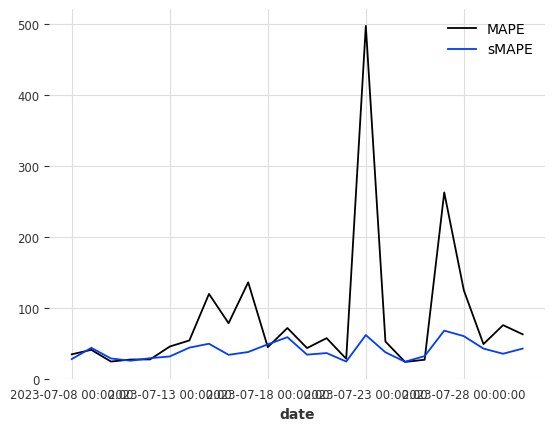

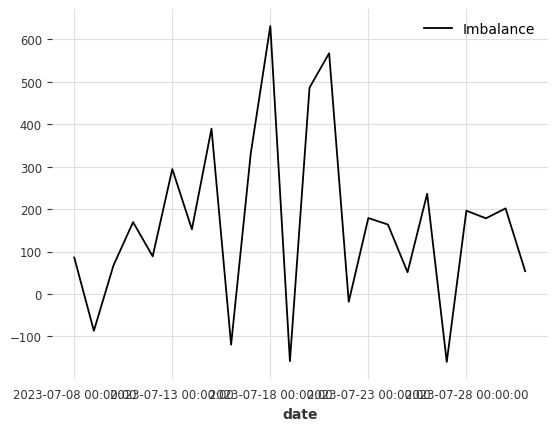

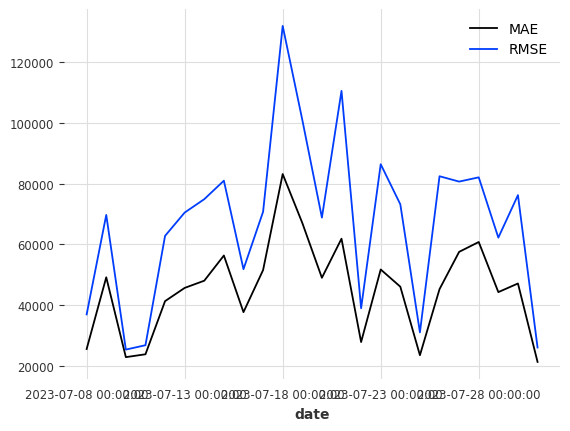

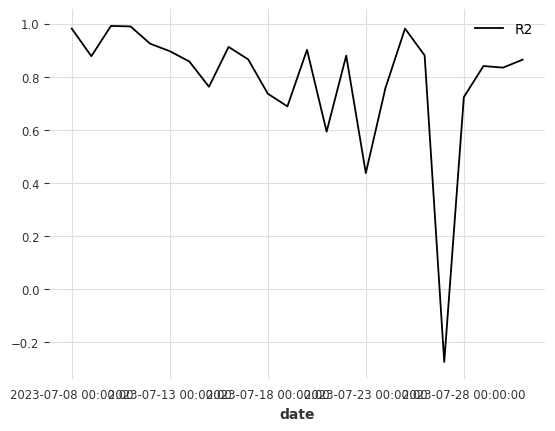

In [83]:


baseline_metrics.iloc[:-1].set_index('date')[['MAPE', 'sMAPE']].plot()
baseline_metrics.iloc[:-1].set_index('date')[['Imbalance']].plot()
baseline_metrics.iloc[:-1].set_index('date')[['MAE', 'RMSE']].plot()
baseline_metrics.iloc[:-1].set_index('date')[['R2']].plot()

### Plot Predictions vs Actuals

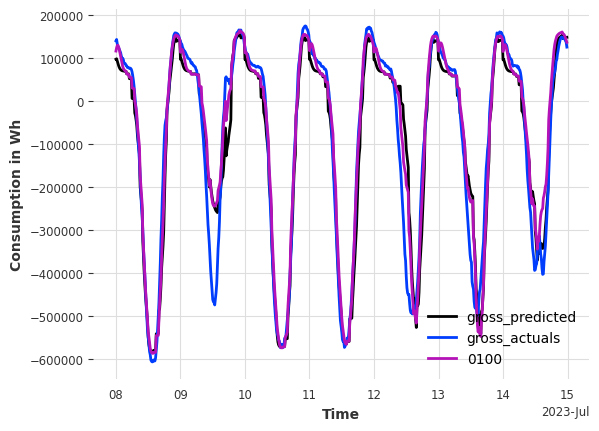

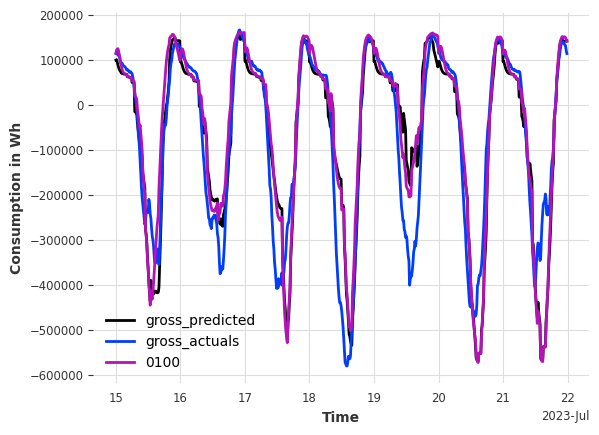

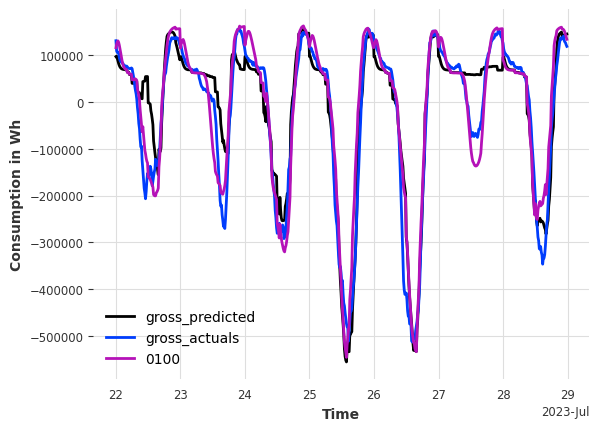

In [136]:
f = ts_1000.stack(ts_0100[['gross_predicted']].with_columns_renamed('gross_predicted', '0100'))

for i in range(0, 3):
    ax = f[i*672:(i+1)*672].plot(new_plot=True)
    ax.set_ylabel('Consumption in Wh')
    ax.set_xlabel('Time')

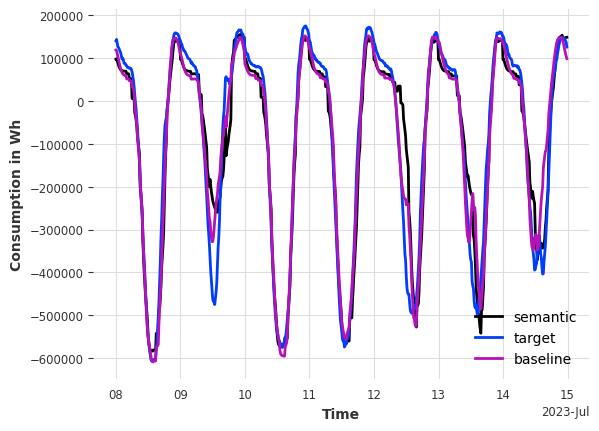

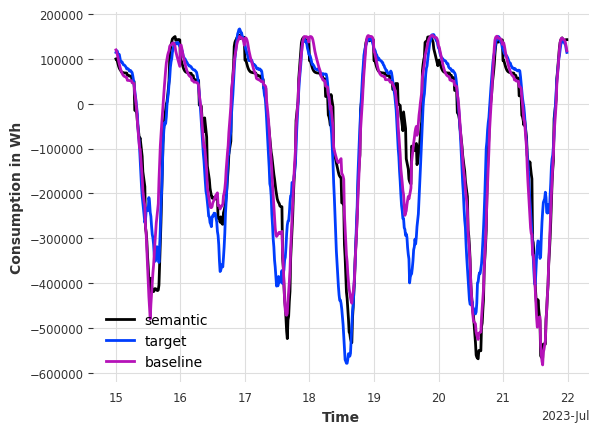

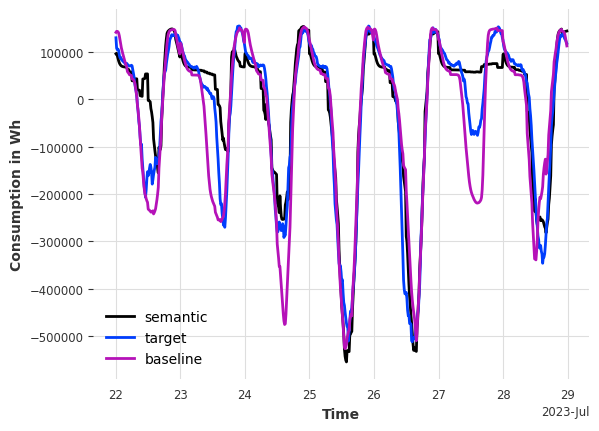

In [132]:
import matplotlib.pyplot as plt

full_ts = ts_1000.stack(ts_0000['gross_predicted'].with_columns_renamed('gross_predicted', 'baseline')).with_columns_renamed(['gross_actuals','gross_predicted'], ['target', 'semantic'])
# full_ts = ts_baseline.with_columns_renamed(['gross_actuals','gross_predicted'], ['target', 'baseline'])

for i in range(0, 3):
    ax = full_ts[i*672:(i+1)*672].plot(new_plot=True)
    ax.set_ylabel('Consumption in Wh')
    ax.set_xlabel('Time')

In [80]:
path = "/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/01_results/20240606_1124_tft_baseline"

# ts_semantic = TimeSeries.from_csv('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/models/20240529_1635_tft_semantic/evaluation_data.csv', time_col='readingdate')
ts_baseline = TimeSeries.from_csv(f'{path}/2023-07-31_2023-07-08_pv_evaluation_data.csv', time_col='readingdate')
baseline_metrics = pd.read_csv(f'{path}/2023-07-31_2023-07-08_pv_metrics.csv')
baseline_metrics.drop(columns='Unnamed: 0', inplace=True)

baseline_metrics.columns

Index(['sMAPE', 'MAPE', 'MAE', 'RMSE', 'R2', 'Imbalance', 'date'], dtype='object')

In [81]:
"""
(non finetuned) TFT baseline

        SMAPE 49.273
        MAPE  85.93
        MAE   52130.492
        RMSE  78998.325
        R2    0.84
"""

baseline_metrics.iloc[-1]

# do WAPE
# SMAPE Improvement: 19.30%
# MAPE Improvement: 2.70%
# MAE Improvement: 12.87%
# RMSE Improvement: 8.05%
# R2 Improvement: 3.69%

sMAPE          39.763
MAPE           83.612
MAE          45419.41
RMSE         72637.97
R2              0.871
Imbalance    3982.225
date             full
Name: 24, dtype: object

### Loading data

In [ ]:

pv_07 = pd.read_csv('../data/2023_07_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
non_pv_07 = pd.read_csv('../data/2023_07_cleaned_non_pv.csv', parse_dates=True).set_index('readingdate')

pv_07.index = pd.to_datetime(pv_07.index)
non_pv_07.index = pd.to_datetime(non_pv_07.index)

pv07_ts = TimeSeries.from_dataframe(pv_07)
non_pv07_ts = TimeSeries.from_dataframe(non_pv_07)

actuals_df = pd.read_csv('../data/2023-04_to_08-amsterdam-actuals_filled_gaps.csv', parse_dates=['datetime_from']).set_index('datetime_from')[[ 'wind_speed', 'global_radiation', 'air_pressure', 'air_temperature', 'relative_humidity' ]]
actuals_df = actuals_df.resample('15min').mean()
# actuals_df['temperature_c'] = actuals_df['air_temperature'].apply(lambda x: convert_temperature(x, 'K', 'C'))
actuals_df = TimeSeries.from_dataframe(actuals_df, freq='15min')

forecasts_df = pd.read_csv('../data/2023_weather_data_06_run_summer_from_04_to_08.csv', parse_dates=['valid_datetime']).set_index('valid_datetime')[[ 'wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m', 'r_instant_ground_2m' ]]
forecasts_df = forecasts_df.resample('15min').ffill()
forecasts_df = TimeSeries.from_dataframe(forecasts_df,freq='15min')